# Introduction

The objective of this document is to explain the methodologies applied within the framework of a data challenge introduced by Olivier Coudray as part of the Advanced Supervised Learning and Data Challenge course during the second year of the Master’s program in Mathematics and Artificial Intelligence at the Institut Mathématique d’Orsay (IMO), Paris-Saclay University. This project focuses on predicting forest cover types for parcels within the Roosevelt National Forest in Colorado, utilizing topographic and environmental data.

In this Jupyter notebook, we systematically explore various supervised learning techniques to tackle this multiclass classification problem. The notebook includes data preprocessing steps, feature engineering, model selection, and evaluation processes. Emphasis is placed on comparing models such as logistic regression, random forests, and gradient-boosting methods. The effectiveness of each approach is assessed through cross-validation, aiming for robust hyperparameter settings that optimize model performance across different data splits.

This document serves as a companion to the notebook, providing detailed explanations of the methods implemented, the rationale behind model selection, and a summary of key results obtained from the analyses.

## Objective

The primary objective of this project is to build a machine learning model capable of predicting the forest cover type for a given parcel based on topographic and soil attributes. The model's predictions will help in identifying forest cover types among seven possible categories, ranging from Spruce/Fir to Krummholz.

The evaluation metric used in this competition is the weighted F1-score, which is suited for this multi-class classification problem. Our goal is to achieve high accuracy in predicting the cover type across all parcels, minimizing misclassification errors and providing a reliable tool for forest cover analysis. The model's performance will be tested on a dataset of approximately 481,000 forest parcels.

## Dataset Overview
![data_description](image/data_description.png)

# Section 1 : Data Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier

In [5]:
data = pd.read_csv("data/train.csv")

In [42]:
data.head()

Unnamed: 0  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0           0       2909      28     18                               182   
1           1       2757     334     30                               212   
2           2       3283     248      4                               150   
3           3       3019     330     14                               541   
4           4       3039     340     20                               474   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              58                             1350   
1                              83                             1384   
2                              15                             5601   
3                            -101                             1811   
4                              74                             3407   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            210             197            117  ...            0   
1            137             184            177  ...            0   
2            211             243            170  ...            0   
3            186             222            175  ...            0   
4            175             207            169  ...            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           2  
1            0            0            0           2  
2            1            0            0           1  
3            0            0            0           2  
4            0            1            0           1  

[5 rows x 56 columns]

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 56 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Unnamed: 0                          100000 non-null  int64
 1   Elevation                           100000 non-null  int64
 2   Aspect                              100000 non-null  int64
 3   Slope                               100000 non-null  int64
 4   Horizontal_Distance_To_Hydrology    100000 non-null  int64
 5   Vertical_Distance_To_Hydrology      100000 non-null  int64
 6   Horizontal_Distance_To_Roadways     100000 non-null  int64
 7   Hillshade_9am                       100000 non-null  int64
 8   Hillshade_Noon                      100000 non-null  int64
 9   Hillshade_3pm                       100000 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  100000 non-null  int64
 11  Wilderness_Area1                    100000 non-null  

**Comment** : 
- No missing values, all values are of type int64
- Spurious column *Unnamed: 0* to be removed from the dataset

In [47]:
# removing column Unnamed: 0
data = data.drop(["Unnamed: 0"], axis = 1)
data.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2909      28     18                               182   
1       2757     334     30                               212   
2       3283     248      4                               150   
3       3019     330     14                               541   
4       3039     340     20                               474   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              58                             1350   
1                              83                             1384   
2                              15                             5601   
3                            -101                             1811   
4                              74                             3407   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            210             197            117   
1            137             184            177   
2            211             243            170   
3            186             222            175   
4            175             207            169   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                2160  ...            0            0   
1                                1570  ...            0            0   
2                                 892  ...            0            0   
3                                2154  ...            0            0   
4                                1879  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            1   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type39  Soil_Type40  Cover_Type  
0            0            0           2  
1            0            0           2  
2            0            0           1  
3            0            0           2  
4            1            0           1  

[5 rows x 55 columns]

# Section 2 : Exploratory Data Analysis

## Univariate analysis
For each feature, we examine its distribution and interaction with the target variable, `Cover_Type` to see how it varies across the different target categories. By examining these relationships, we can identify potential patterns and gain insights into the predictive power of each feature.
But first we start by **Cover Type**.

### Cover Type (Target Variable) 
> This is the classification or label representing the type of forest cover, which the model will be trained to predict using the other features.


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_distribution(data, column, title=None, xlabel=None, ylabel="Count", figsize=(12, 6)):
    
    if title is None:
        title = f"Distribution of {column}"
    if xlabel is None:
        xlabel = column
    
    bar_palette = sns.color_palette("Set2", n_colors=data[column].nunique())

    plt.figure(figsize=figsize)
    sns.countplot(x=column, data=data, hue=column, palette=bar_palette, saturation=0.9, legend = False)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.xticks(fontsize=12, color='black', ha='right')
    plt.yticks(fontsize=12, color='black')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [54]:
data["Cover_Type"].value_counts()

Cover_Type
2    48676
1    36410
3     6273
7     3568
6     2967
5     1635
4      471
Name: count, dtype: int64

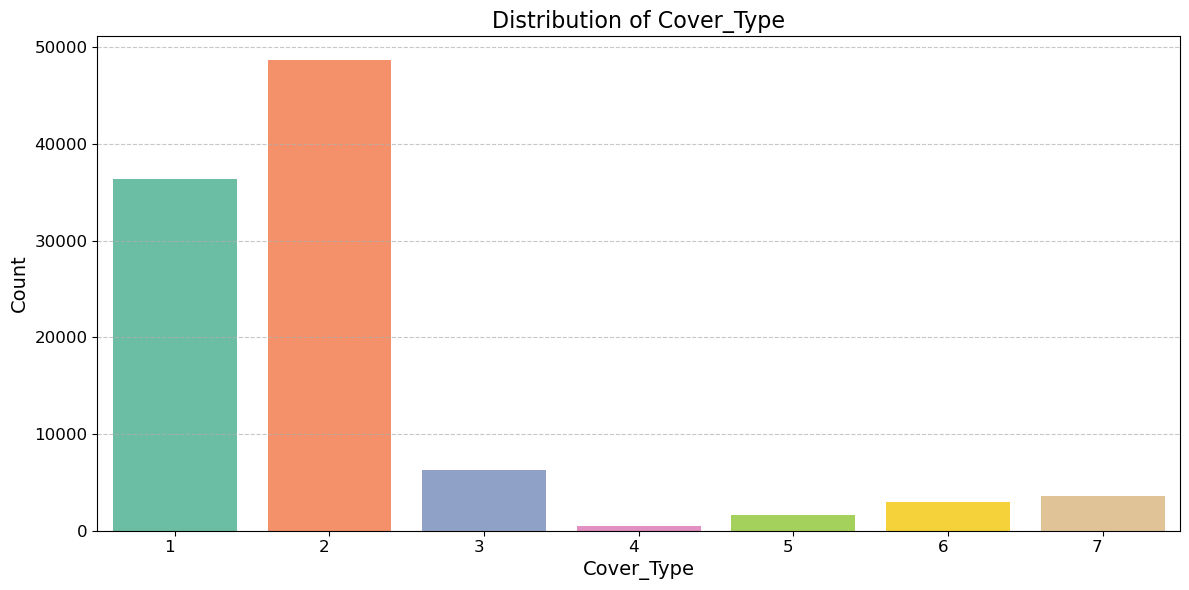

In [56]:
plot_category_distribution(data, "Cover_Type")

**Observations:**
- The dataset is **highly imbalanced**, with **Cover Types 1 and 2 dominating the distribution**, while some classes like Cover Types 3, 4, and 5 have very few observations.
- This imbalance might impact model performance, especially if a classification model is built to predict the forest cover type.
- Special care needs to be taken to handle the imbalance (e.g., by applying techniques like oversampling, undersampling, or using balanced class weights). (see model training/ feature engineering)?!!!!

In [59]:
def category_imbalance(counts, k, full_summary = False, return_counts=False):
   
    # Sort the counts in descending order (from most frequent to least frequent)
    sorted_counts = counts.sort_values(ascending=False)
    
    if k <= 0 or k >= len(sorted_counts):
        raise ValueError(f"k must be between 1 and {len(sorted_counts)-1} (inclusive)")

    major_categories = sorted_counts.iloc[:k].sum()  # Top-k most frequent categories
    minor_categories = sorted_counts.iloc[k:].sum()  # Remaining less frequent categories

    # Compute imbalance ratio
    imbalance_ratio = minor_categories / major_categories

    # Print summary
    if full_summary:
        print(f"Major categories: {sorted_counts.index[:k].tolist()} have a total count of {major_categories} representing {major_categories / sorted_counts.sum() * 100:.2f}% of the total")
        print(f"Minor categories: {sorted_counts.index[k:].tolist()} have a total count of {minor_categories} representing {minor_categories / sorted_counts.sum() * 100:.2f}% of the total")
    else:
        print(f"Major (Top-{k}) categories represent {major_categories / sorted_counts.sum() * 100:.2f}% of the total")
        print(f"Minor categories represent {minor_categories / sorted_counts.sum() * 100:.2f}% of the total")
    
    print(f"Imbalance ratio (minor vs major categories): {imbalance_ratio * 100:.2f}%")

    if return_counts:
        return sorted_counts

In [61]:
category_imbalance(data["Cover_Type"].value_counts(), 2, True, True)

Major categories: [2, 1] have a total count of 85086 representing 85.09% of the total
Minor categories: [3, 7, 6, 5, 4] have a total count of 14914 representing 14.91% of the total
Imbalance ratio (minor vs major categories): 17.53%


Cover_Type
2    48676
1    36410
3     6273
7     3568
6     2967
5     1635
4      471
Name: count, dtype: int64

In [63]:
category_imbalance(data["Cover_Type"].value_counts(), 3)

Major (Top-3) categories represent 91.36% of the total
Minor categories represent 8.64% of the total
Imbalance ratio (minor vs major categories): 9.46%


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distribution_and_boxplot(feature, data):

    box_palette = sns.color_palette("Set2", n_colors=data['Cover_Type'].nunique())
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})
    
    sns.histplot(data[feature], kde=False, color='skyblue', ax=ax[0])
    ax[0].set_title(f'Distribution of {feature}')
    
    sns.boxplot(x='Cover_Type', y=feature, data=data, palette=box_palette, hue='Cover_Type', dodge=False, ax=ax[1])
    ax[1].set_title(f'{feature} vs Cover Type')
    ax[1].legend_.remove()
    
    plt.tight_layout()
    plt.show()

### Elevation

>Different types of forest cover tend to exist at varying elevations. Higher elevations often support species adapted to cooler temperatures and lower oxygen levels, whereas lower elevations typically host species that thrive in warmer, more oxygen-rich conditions<sup><a href="#ref1">[1]</a></sup>.  **Hence we expect this feature to have strong predictive power.**

<h3 id="references">References</h3>

<p id="ref1">[1] Körner, C. (2007). The use of ‘altitude’ in ecological research. <i>Trends in Ecology & Evolution</i>, 22(11), 569-574. doi:10.1016/j.tree.2007.09.006</p>


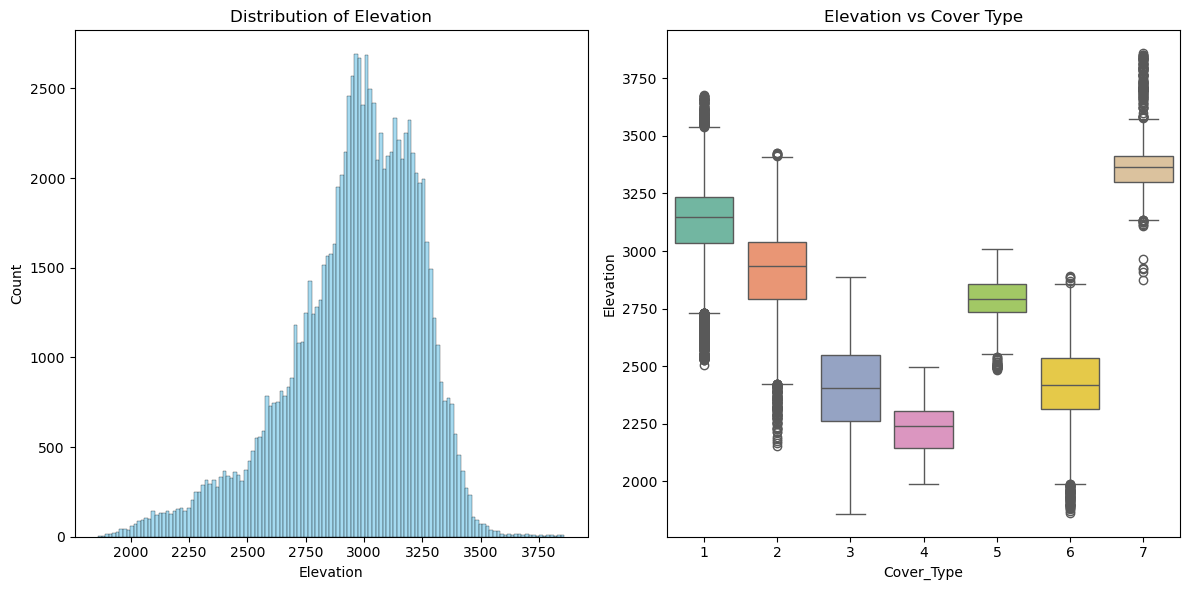

In [69]:
plot_feature_distribution_and_boxplot('Elevation', data)

**Observations** :
- There is a clear differentiation in elevation ranges across the different cover types, **which suggests that elevation might be an important factor in distinguishing the forest cover types.**
- Certain cover types **(e.g., 7 and 1)** tend to occur at higher elevations, while others **(e.g., 3 and 4)** are more common at lower elevations.
- Outliers are present in most of the boxplots, particularly in **cover types 1, 6, and 7**, indicating some extreme elevation values for these categories.

### Aspect

>The aspect of a slope measures its compass direction (in degrees azimuth). The direction a slope faces can significantly influence microclimate conditions, such as sunlight exposure, temperature, and wind. These conditions in turn affect the types of vegetation that can thrive on a given slope. For instance, north-facing slopes in the Northern Hemisphere generally receive less sunlight and are cooler, while south-facing slopes receive more sunlight and are warmer. These variations in microclimate contribute to distinct vegetation patterns<sup><a href="#ref2">[2]</a></sup>.

**References**

<p id="ref2">[2] Cantlon, J. E. (1953). Vegetation and microclimates on north and south slopes of Cushetunk Mountain, New Jersey. <i>Ecological Monographs</i>, 23(3), 241-270. doi:10.2307/1943599</p>


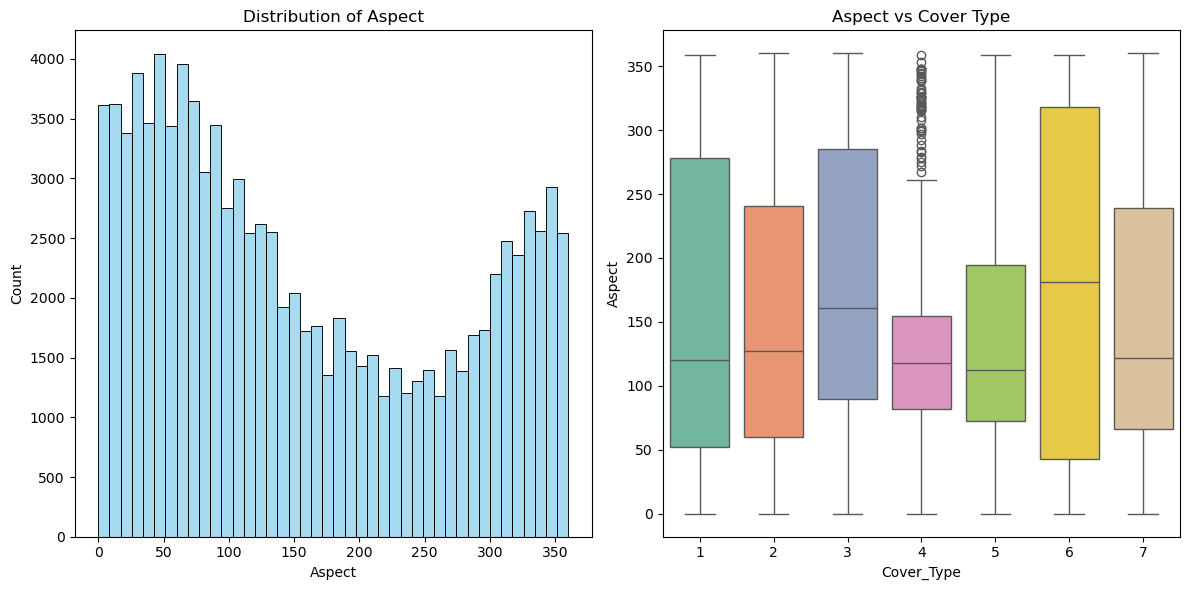

In [73]:
plot_feature_distribution_and_boxplot('Aspect', data)

**Observations** :
- The distribution appears **bimodal**, with two peaks: one around 0-50 degrees and another around 300-360 degrees.
- Aspect seems to have some relationship with certain cover types, particularly **Cover Type 3**, which tends to have lower aspect values.
- This indicates that Aspect may have some predictive value, but it is less distinctly correlated with specific cover types compared to Elevation

### Slope

> The steepness of a slope can greatly influence soil moisture retention, erosion rates, and sunlight exposure. These factors impact the types of vegetation that can establish and thrive. Steeper slopes, for example, are often prone to higher erosion and may have thinner soil layers, which affects water retention and limits certain plant types. In contrast, gentler slopes tend to accumulate more soil and moisture, allowing different types of forest vegetation to grow<sup><a href="#ref3">[3]</a></sup>.

**References**

<p id="ref3">[3] Parker, A. J. (1982). The topographic relative moisture index: An approach to soil-moisture assessment in mountain terrain. <i>Physical Geography</i>, 3(2), 160-168. doi:10.1080/02723646.1982.10642213</p>


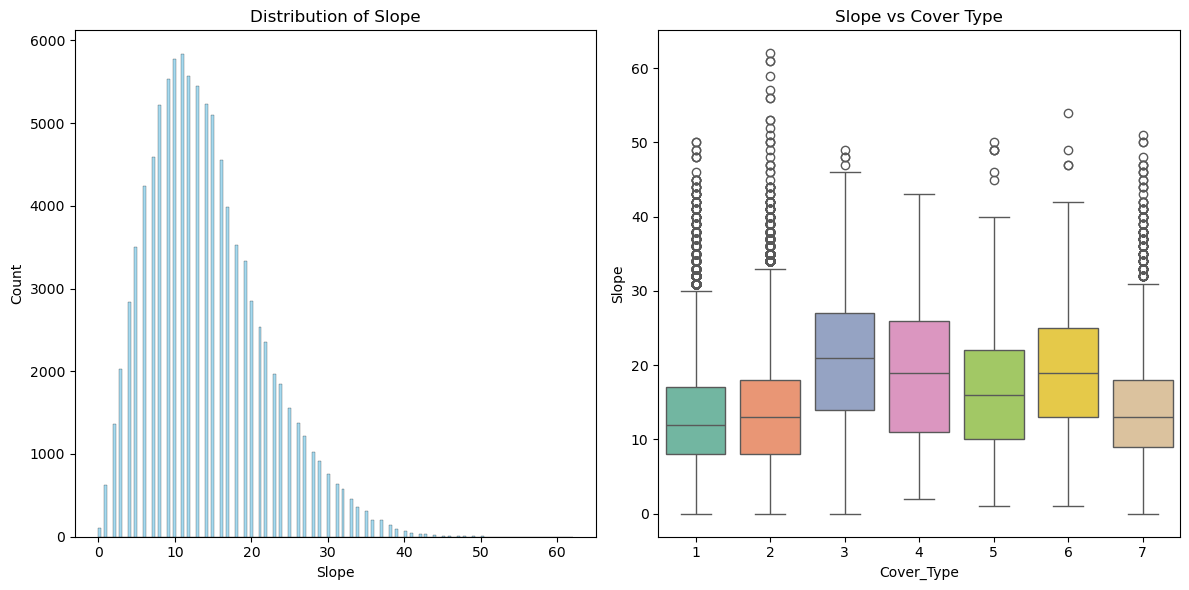

In [77]:
plot_feature_distribution_and_boxplot('Slope', data)

**Observations:**
- Slope ranges between 0 to 60 degrees and the distribution is **right skewed**.
- The majority of the forest areas have mild to moderate slopes (around 13°), with steep slopes being relatively rare. 
- **Slope doesn't seem to show very strong separation between cover types**, but still some information could be extracted from this feature.

### Horizontal and Vertical Distance to Hydrology
>Proximity to water bodies can influence soil moisture and nutrient availability, which are critical factors for forest types. Different cover types may be associated with areas closer or farther from water bodies.

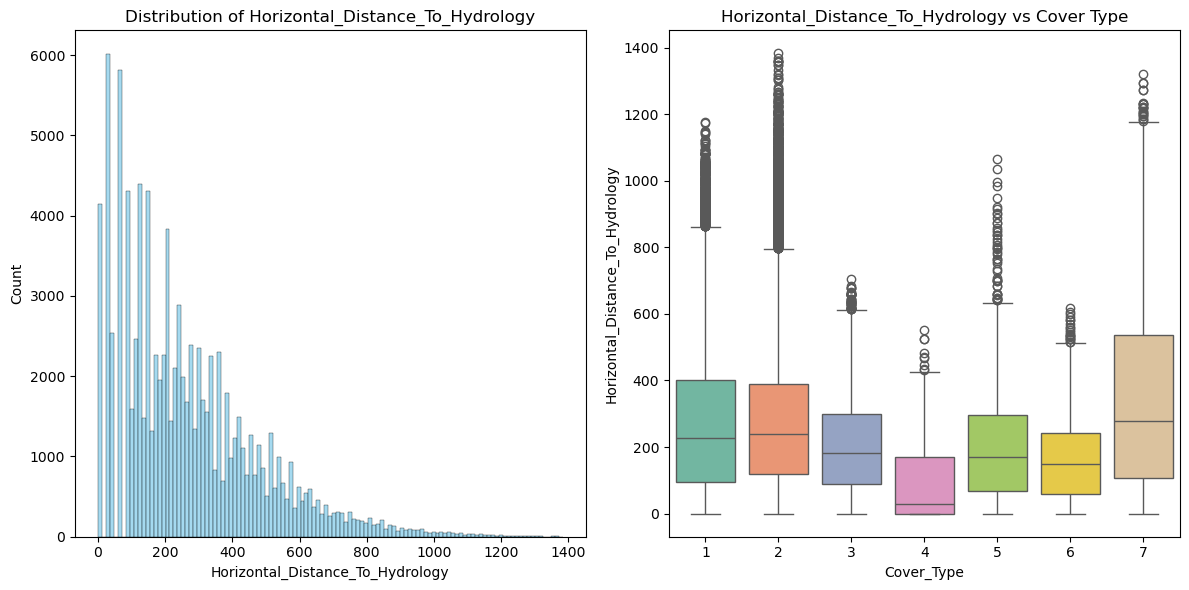

In [81]:
plot_feature_distribution_and_boxplot('Horizontal_Distance_To_Hydrology', data)

**Observations:**
-  Most locations are relatively close to hydrological features, but there are significant differences between cover types in terms of horizontal distance.
- **Cover Type 6** is associated with the largest horizontal distances from hydrological features, while **Cover Type 3** tends to have the smallest.

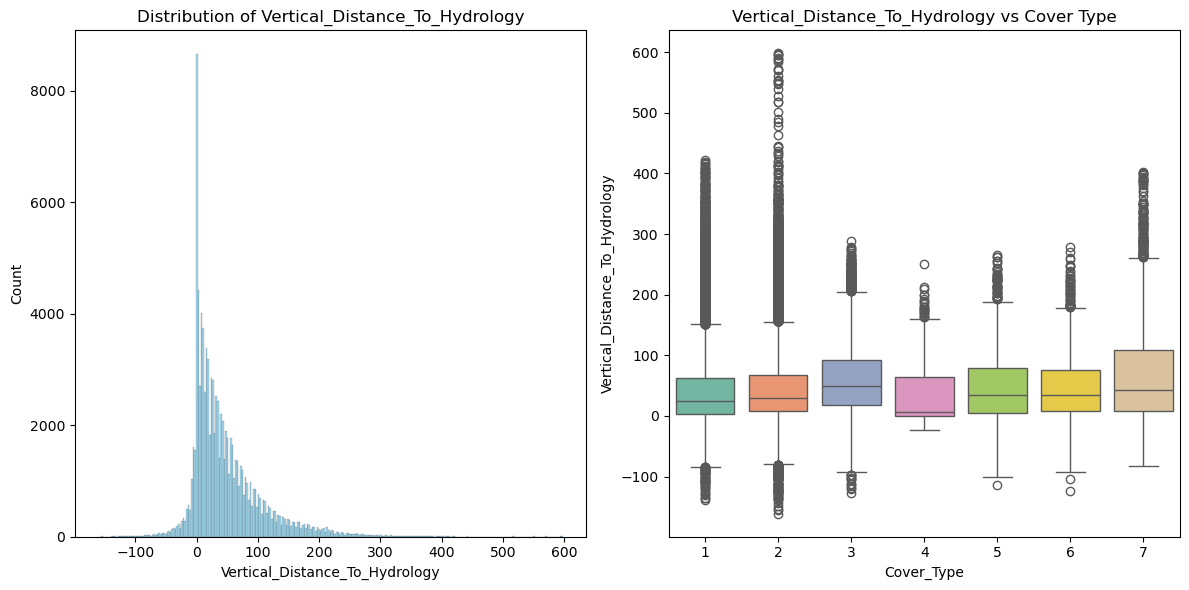

In [83]:
plot_feature_distribution_and_boxplot('Vertical_Distance_To_Hydrology', data)

**Observations:**
- The distribution is highly right-skewed, with a large peak at 0. **This suggests that many data points have little to no vertical distance to hydrology.**
- The values can become negative, suggesting forests below the hydrological level.
- **Vertical_Distance_To_Hydrology does not seem to strongly differentiate between the cover types.** It may need to be combined with other distance features to provide more value in distinguishing between cover types. (see feature engineering !!!!!!!)

### Horizontal Distance to Roadways
>Roads indactes nearby human activity which is expected to cause disturbances forest ecosystem. We know that the humain activity have a big impact on nature in general **so we expect this feature to have a big impact on the type of forestation**.

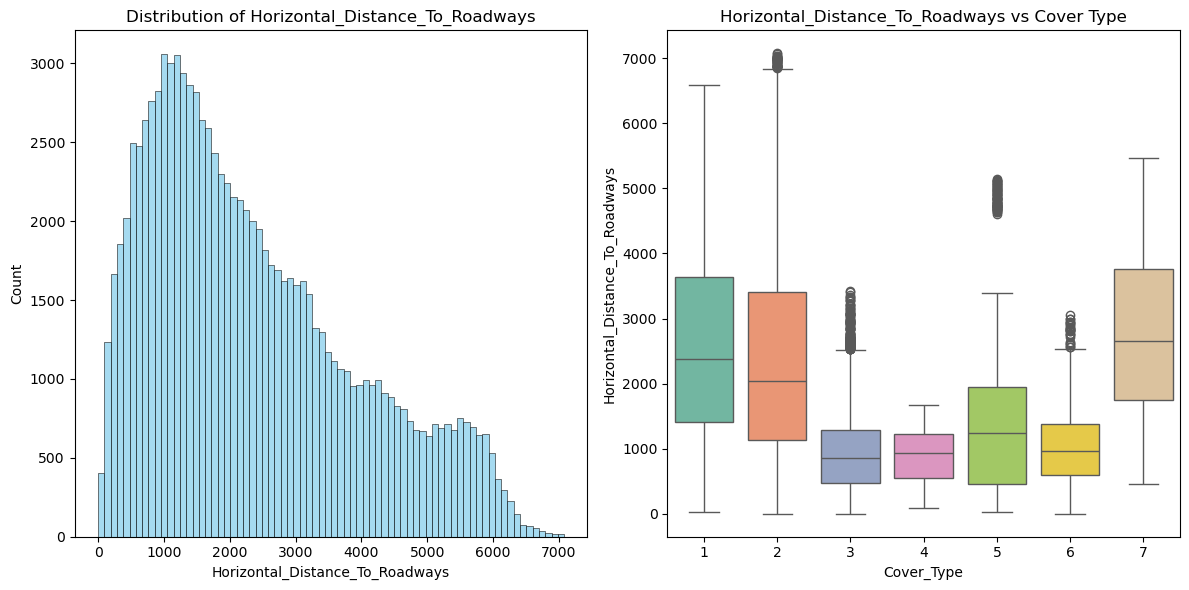

In [88]:
plot_feature_distribution_and_boxplot('Horizontal_Distance_To_Roadways', data)

**Observations:**
- The distribution is **right-skewed**, with most observations clustered between 0 and 3000 meters.
- Horizontal_Distance_To_Roadways **has a noticeable impact on cover types**. For e.g, **Cover Type 6** tends to occur farthest from roadways, while **Cover Types 3 and 2** tend to be located closer to roadways.

### Hillshade (9 am, Noon, 3 pm)

>The hillshade values at 9 am, noon, and 3 pm provide insights into the amount of sunlight a specific area receives throughout the day. Sunlight exposure influences the microclimate and thus affects the types of vegetation that can thrive in a given area. For instance, certain tree species are adapted to high sunlight exposure, while others prefer shaded environments. Understanding sunlight patterns can therefore be crucial in predicting forest cover types<sup><a href="#ref4">[4]</a></sup>.

**References**

<p id="ref4">[4] Hutchinson, B. A., & Matt, D. R. (1977). The distribution of solar radiation within a deciduous forest. <i>Ecological Monographs</i>, 47(2), 185-207. doi:10.2307/1942615</p>


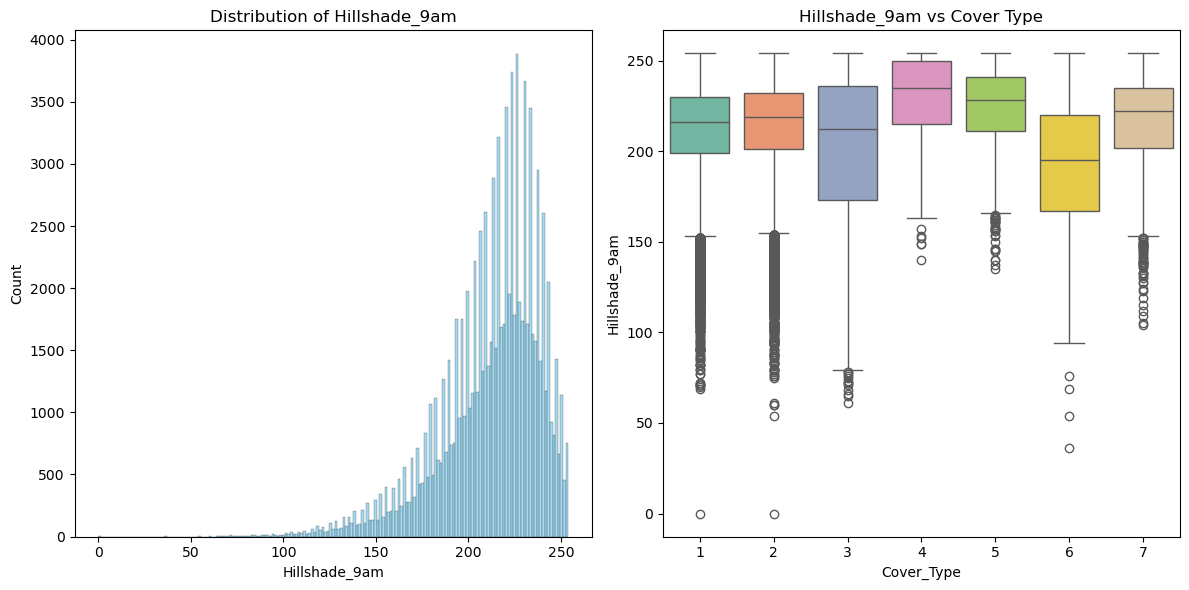

In [92]:
plot_feature_distribution_and_boxplot('Hillshade_9am', data)

**Observations:**
- The distribution is **right-skewed**, with most values clustered between 150 and 250.
- There are fewer observations with low hillshade values (less than 100), **indicating that most areas receive a moderate to high amount of sunlight at 9am**
- **Cover Type 3** has the narrowest distribution with few outliers, suggesting more consistent exposure.
- **The presence of many outliers in Cover Types 1 and 2** indicates variability in sunlight exposure for these areas, which may be influenced by factors like slope or aspect.

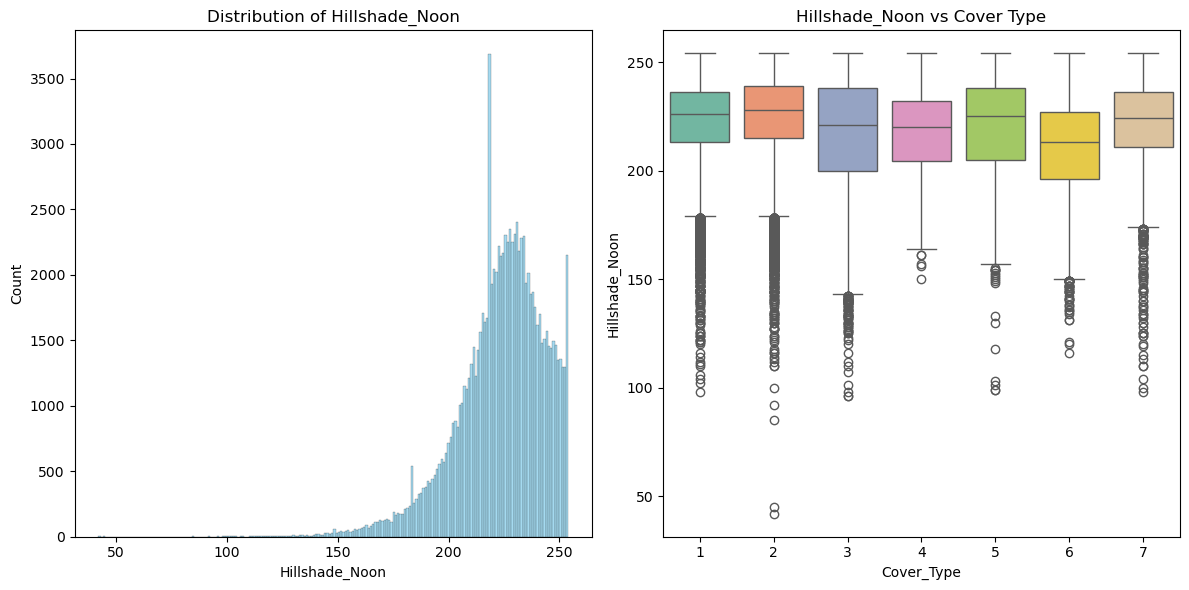

In [95]:
plot_feature_distribution_and_boxplot('Hillshade_Noon', data)

**Observations:**
- The distribution is **right-skewed**, with most values clustered between 180 and 250.
- There are fewer observations with low hillshade values (less than 150), **indicating that most areas receive a moderate to high amount of sunlight at Noon**
- Hillshade_Noon exhibits **slight variations** across different cover types, we expect then this feature to have **lower predictive power.**

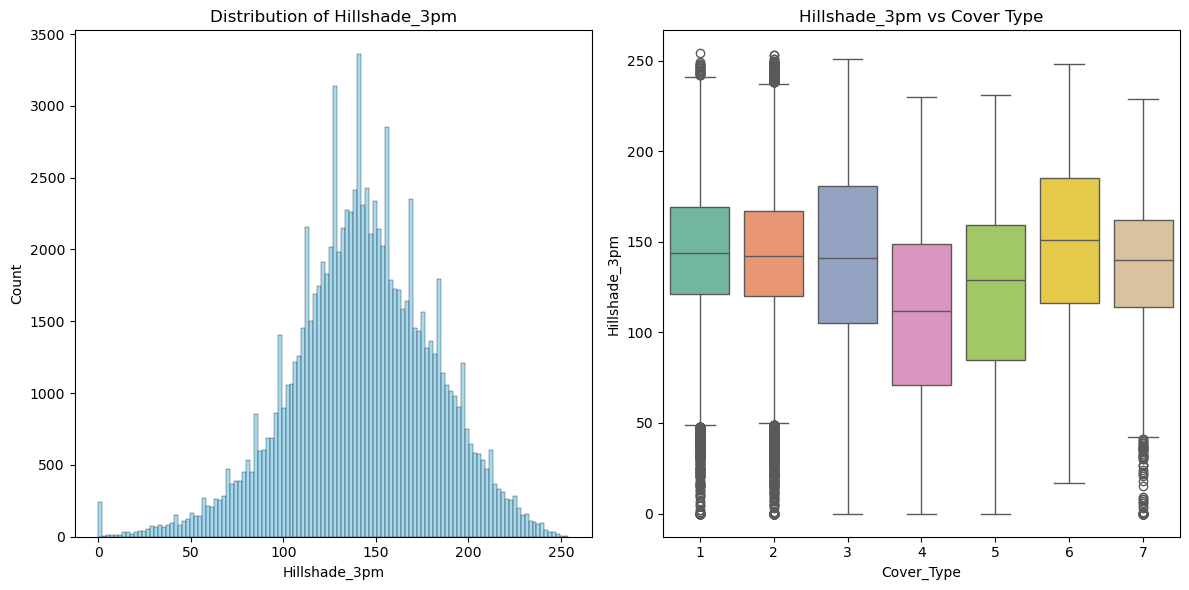

In [98]:
plot_feature_distribution_and_boxplot('Hillshade_3pm', data)

**Observations:**
- The distribution is almost **normal** but shows right-skew, with most values concentrated between 100 and 200.
- **Cover type 3** shows tendency to have lower amount of sunlight at 3pm.

### Horizontal Distance to Fire Points
>Forest types may differ in areas more prone to wildfires, as some trees are more resistant to fires or regenerate more easily in fire-prone areas. Hence we expect this parameter to **have high predictive power in terms of cover type.**

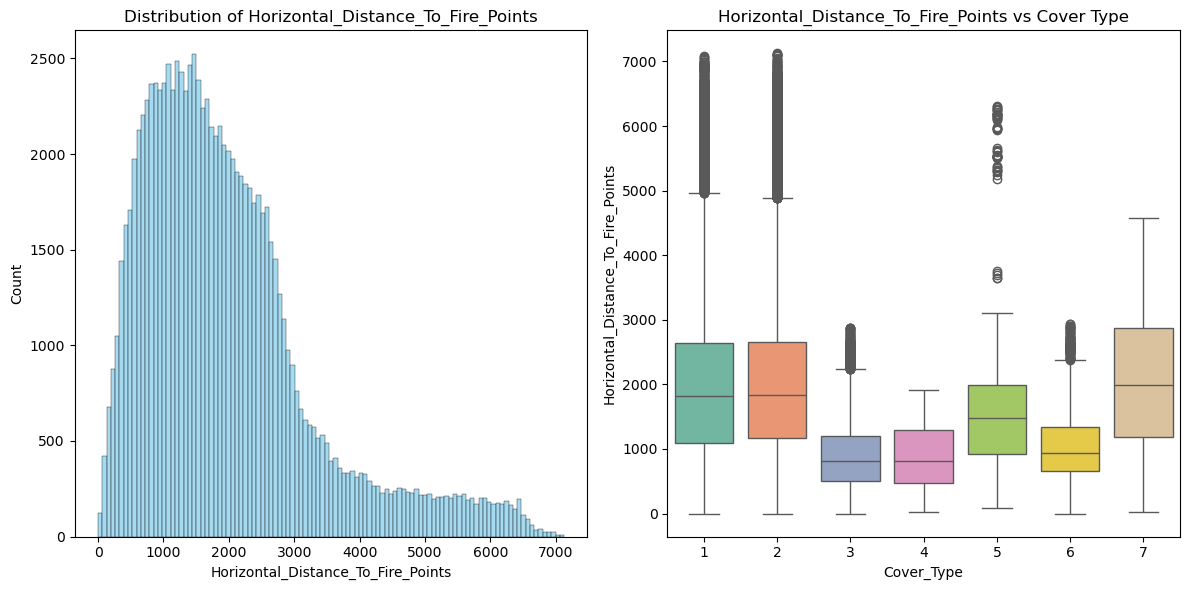

In [102]:
plot_feature_distribution_and_boxplot('Horizontal_Distance_To_Fire_Points', data)

**Observations:**
- The distribution is **right-skewed**, with most observations clustered between 500 and 2500 meters.
- The distribution shows a slow tapering off after 3000 meters, indicating that fewer points are far from fire locations.
- **Horizontal_Distance_To_Fire_Points seems to shows strong degree** of separation between cover types, with **Cover Types 2 and 3** being closer to fire points, while for e.g **Cover Type 6** tends to be farther away.

### Soil Type

>The presence of different soil types plays a significant role in determining forest cover, as trees and vegetation have varying tolerances and preferences for soil conditions such as drainage, pH, and nutrient availability. For example, certain forest types thrive in well-drained soils, while others require soils that retain moisture. Soil characteristics thus directly impact the distribution of vegetation and forest cover types
<sup><a href="#ref5">[5]</a></sup>.
>
**References**

<p id="ref5">[5] Brady, N. C., & Weil, R. R. (2008). *The Nature and Properties of Soils* (14th ed.). Pearson Education. This comprehensive reference discusses soil characteristics and their influence on vegetation.</p>

In [106]:
def count_ones_per_row(data, binary_columns):
    count_per_row = data[binary_columns].sum(axis=1)
    print(f"Total number of ones across all rows: {count_per_row.sum()}")
    return count_per_row

In [108]:
soil_types_cols = [f"Soil_Type{i}" for i in range(1, 41)]
count_ones_per_row(data, soil_types_cols)

Total number of ones across all rows: 100000


0        1
1        1
2        1
3        1
4        1
        ..
99995    1
99996    1
99997    1
99998    1
99999    1
Length: 100000, dtype: int64

**Conclusion:** 
- We conclude that each forest has a unique soil type.
- One can infer that `Soil_Type{i}` columns are just the onehot-encoding for values spaning from 1 to 40. Also since these numbers based on the USFS Ecological Code **more informations can be extracted from the name of each type.** (see feature engineering!!!!!)
> To **simplify** the analysis of soil types, we are going to **create a single new column called Soil_Type_Index** that will represent the actual soil type as an integer between 1 and 40. This will correspond to the index of the column that has a 1 in the original one-hot encoding.

In [111]:
# List of all Soil_Type columns (assumes they are named Soil_Type1 to Soil_Type40)
soil_cols = [f'Soil_Type{i}' for i in range(1, 41)]

# Create a new column 'Soil_Type_Index' by finding the index of the '1' in the one-hot encoding
data['Soil_Type_Index'] = data[soil_cols].idxmax(axis=1)

# Convert 'Soil_Type_Index' from 'Soil_TypeX' to integer X
data['Soil_Type_Index'] = data['Soil_Type_Index'].apply(lambda x: int(x.split('Type')[-1]))

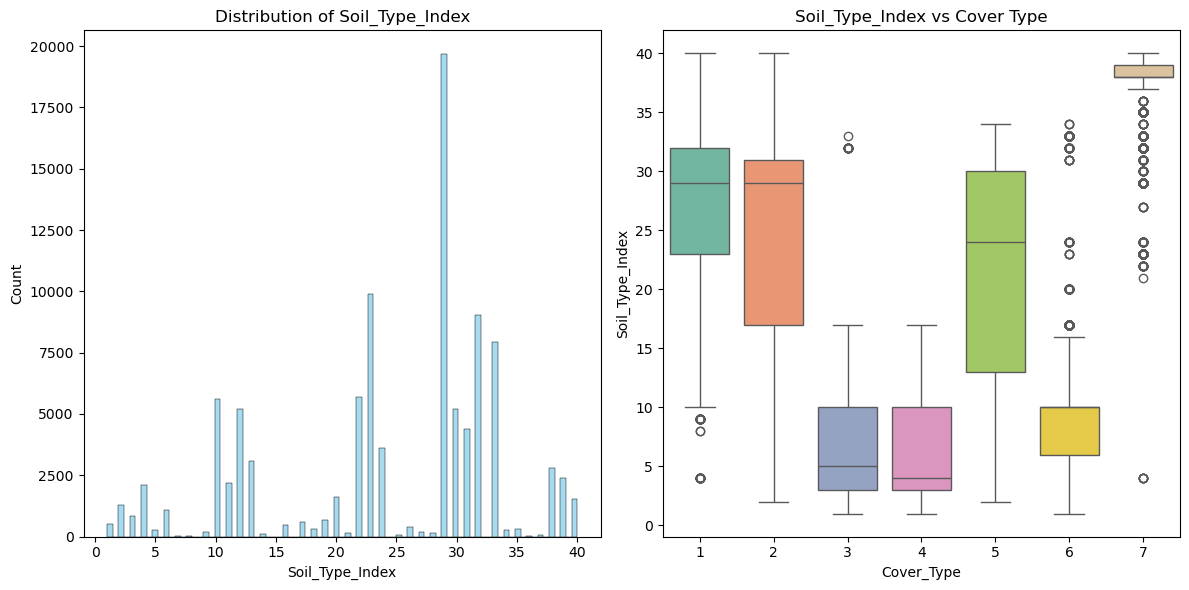

In [113]:
plot_feature_distribution_and_boxplot('Soil_Type_Index', data)

**Observations:**
- There is a highly **uneven distribution** of soil types. Some **soil types (like type 29 and 23) dominate the dataset** with over 10,000 observations, while other soil types (e.g., 2, 5, 7, etc.) are much less frequent.
- **Cover Type 6** seems to be strongly related to the higher range of soil types (around 40).
- This new column present a **strong predictive signal**. We are going to further use this column and add more ones based on the explanation of USFS Ecological Code for each value. (feature engineering !!!!)

### Wilderness Area
>This indicates whether a forest lies within a protected or non-protected wilderness area, which may affect management practices like logging and fire control, and thus influence forest cover type.

In [117]:
# Wilderness Area distribution
wilderness_cols = [f'Wilderness_Area{i}' for i in range(1,5)]
count_ones_per_row(data, wilderness_cols)

Total number of ones across all rows: 100000


0        1
1        1
2        1
3        1
4        1
        ..
99995    1
99996    1
99997    1
99998    1
99999    1
Length: 100000, dtype: int64

**Conclusion:** 
- We make similar conclusions as for soil type columns.
> We follow a similar approach as done for soil type columns and we **create a single new column called Wilderness_Area_Index** that will represent the actual wilderness area as an integer between 1 and 4. This will correspond to the index of the column that has a 1 in the original one-hot encoding.

In [120]:
data['Wilderness_Area_Index'] = data[wilderness_cols].idxmax(axis=1)
data['Wilderness_Area_Index'] = data['Wilderness_Area_Index'].apply(lambda x: int(x.split('Area')[-1]))

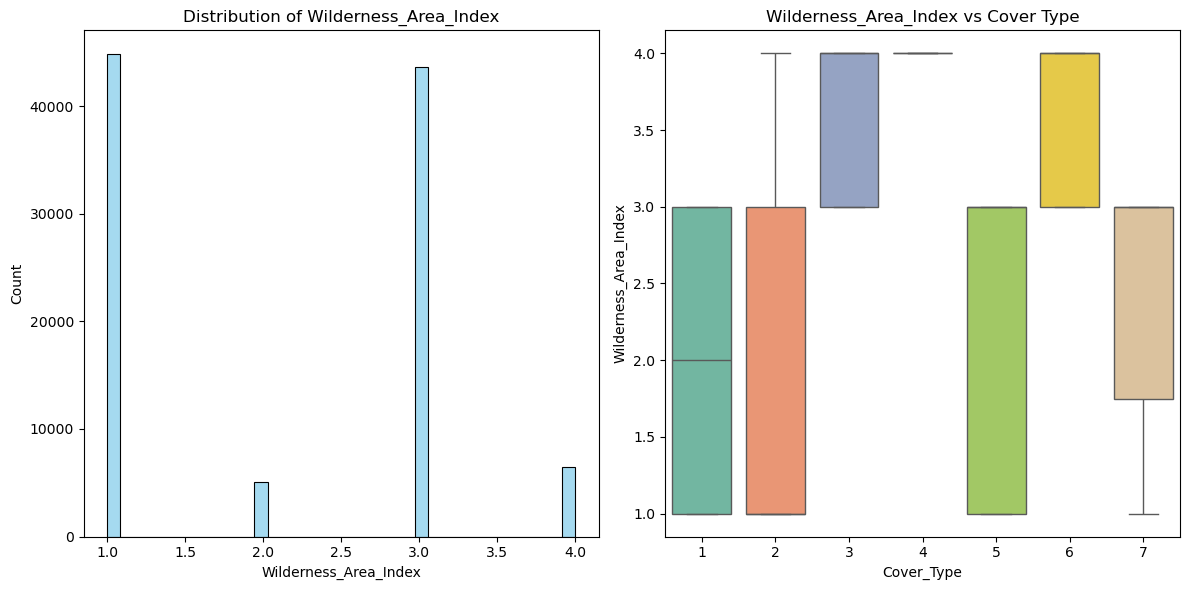

In [122]:
plot_feature_distribution_and_boxplot('Wilderness_Area_Index', data)

**Observations:**
- Wilderness Area 1 and Wilderness Area 3 dominate the dataset
- **Wilderness_Area_Index shows a clear predictive signal** to deduce certain cover types, for e.g **Cover Type 6** has a strong association with **Wilderness Area 1** (feature engineering !)

### Conclusion of Univariate Analysis:
The analysis revealed distinct patterns and distributions that suggest certain features may have a strong influence on the target variable, Cover Type. In particular, features like **Elevation, Soil Type, and Wilderness Area** showed significant variability across different cover types, indicating their potential **importance for predictive modeling**. Additionally, the dataset includes **imbalances** in certain features, such as soil types and wilderness areas, which should be considered when moving forward.

## Bivariate analysis

In this phase, we will explore the relationships between pairs of features to understand how they influence one another and the target variable, `Cover Type.`

In [127]:
# List of quantitative features
quantitative_features = ['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area_Index',
 'Soil_Type_Index']

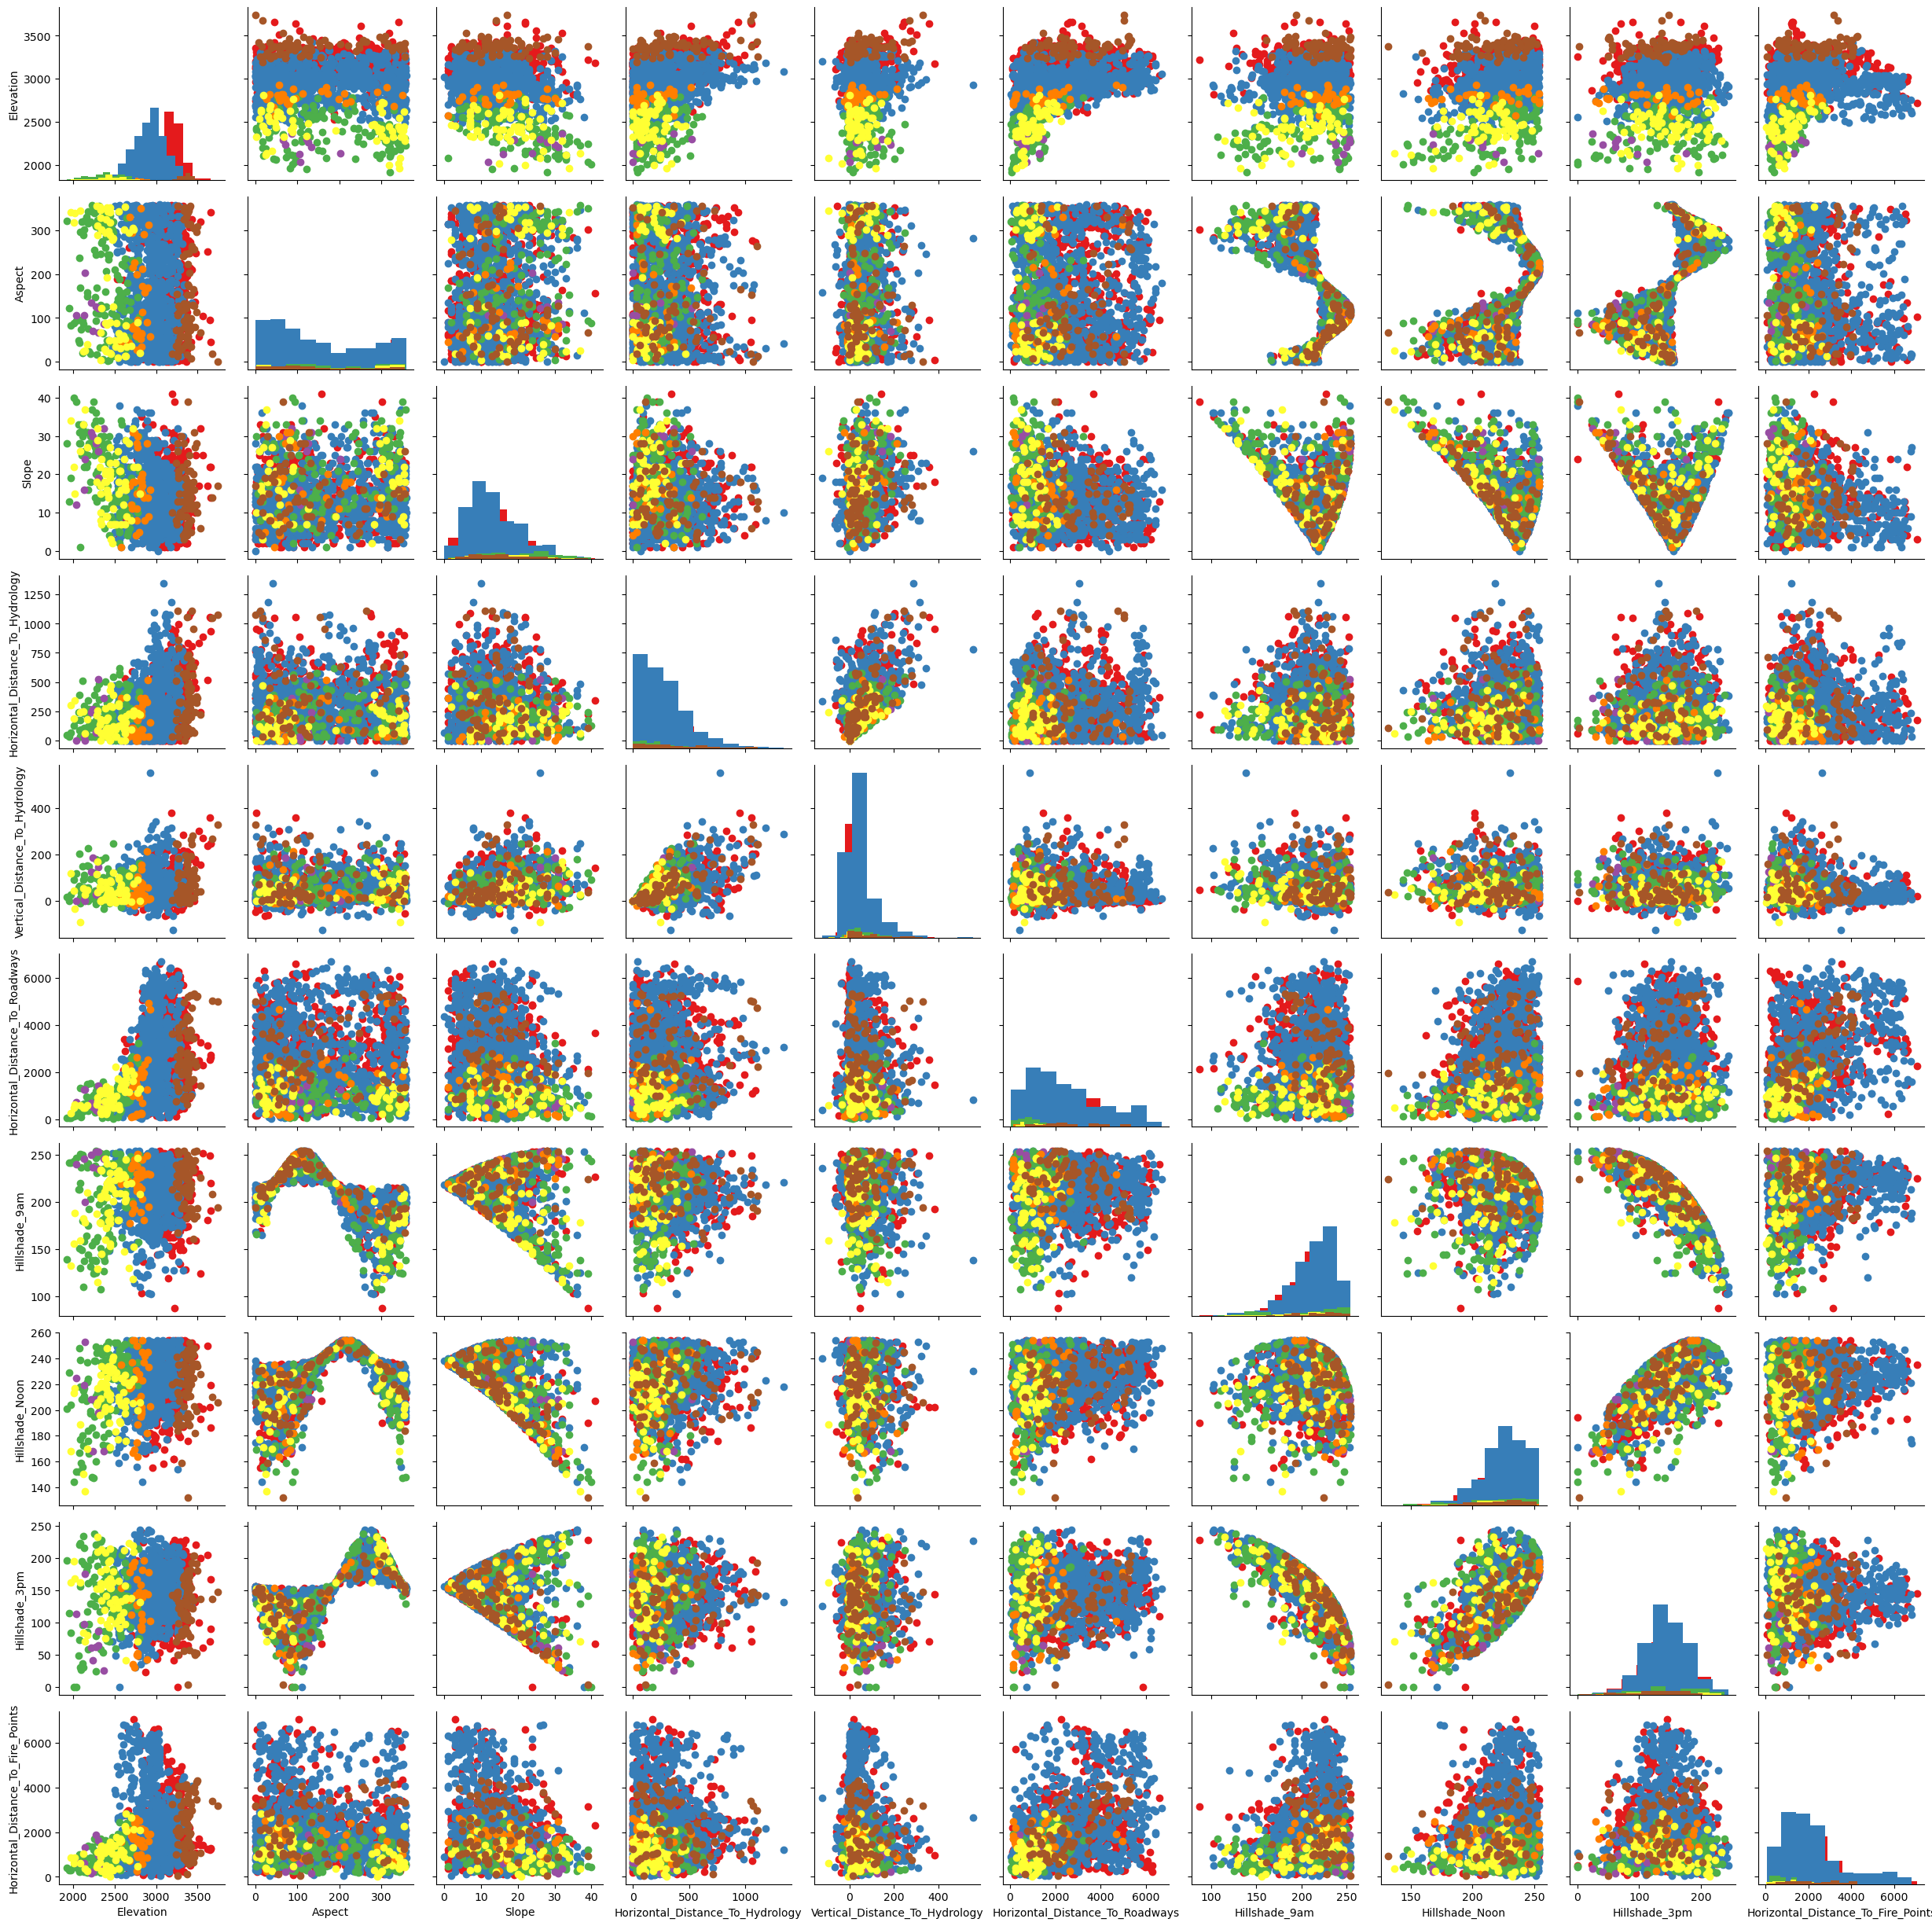

In [89]:
g = sns.PairGrid(data.sample(2000), vars=quantitative_features[:-2], hue='Cover_Type', palette='Set1')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.show()

**Observations:**
- Many of the pairwise scatterplots (off-diagonal) show **non-linear relationships** between features:
    - There appears to be some curved relationship between features, suggesting potential feature engineering to capture this relation (for e.g : **Slope vs Hillshade**)
    - **Elevation** plots shows distinct clusters based on Cover Type, meaning certain forest types are more likely to be found at specific elevation ranges.

### Mutual Information
Let's now quantitatively compare each quantitative feature in terms of its ability to explain the target variable (Cover Type). In the univariate analysis, we conducted a micro analysis, focusing on detailed insights. This analysis provides a macro perspective, giving us a broader understanding of how each feature contributes to predicting the target.

>#### Formula:
> $I(X;Y)$ between two variables $X$ and $Y$ quantifies how much information about $Y$ is provided by knowing $X$. It is defined as:
>
$$
I(X; Y) = \sum_{x \in X} \sum_{y \in Y} p(x, y) \log \left( \frac{p(x, y)}{p(x) p(y)} \right)
$$
>
> Where:
> - $p(x)$ and $p(y)$ are the marginal probabilities of $X$ and $Y$, respectively.
> - $p(x, y)$ is the joint probability of $X$ and $Y$.
> - The logarithm is base 2, so mutual information is typically measured in bits.
>
> #### Interpretation:
> - Mutual Information measures how much knowledge of one variable reduces uncertainty about another.
> - A high MI value means that knowing the feature $X$ gives significant information about $Y$ (in this case, the target variable).
> - MI is non-negative, and $I(X; Y) = 0$ means $X$ and $Y$ are independent.


In [129]:
from sklearn.feature_selection import mutual_info_classif

def plot_mutual_information(data, quantitative_features, target_feature):

    # Compute mutual information between quantitative features and target
    X = data[quantitative_features]
    y = data[target_feature]
    mutual_info = mutual_info_classif(X, y)

    # Sort mutual information scores for each feature
    mi_scores = pd.Series(mutual_info, index=quantitative_features)
    mi_scores = mi_scores.sort_values(ascending=False)

    print(mi_scores)

    # Define plot config
    palette = sns.color_palette("coolwarm", len(mi_scores))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, hue=mi_scores.index, palette=palette, dodge=False, legend=False)
    plt.title('Mutual Information Scores for Quantitative Features', fontsize=16)
    plt.xlabel('Mutual Information Score', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Elevation                             0.463637
Soil_Type_Index                       0.408339
Wilderness_Area_Index                 0.195837
Horizontal_Distance_To_Roadways       0.091693
Horizontal_Distance_To_Fire_Points    0.065984
Slope                                 0.033996
Hillshade_9am                         0.031639
Hillshade_Noon                        0.023898
Hillshade_3pm                         0.023467
Aspect                                0.022937
Horizontal_Distance_To_Hydrology      0.022401
Vertical_Distance_To_Hydrology        0.017819
dtype: float64


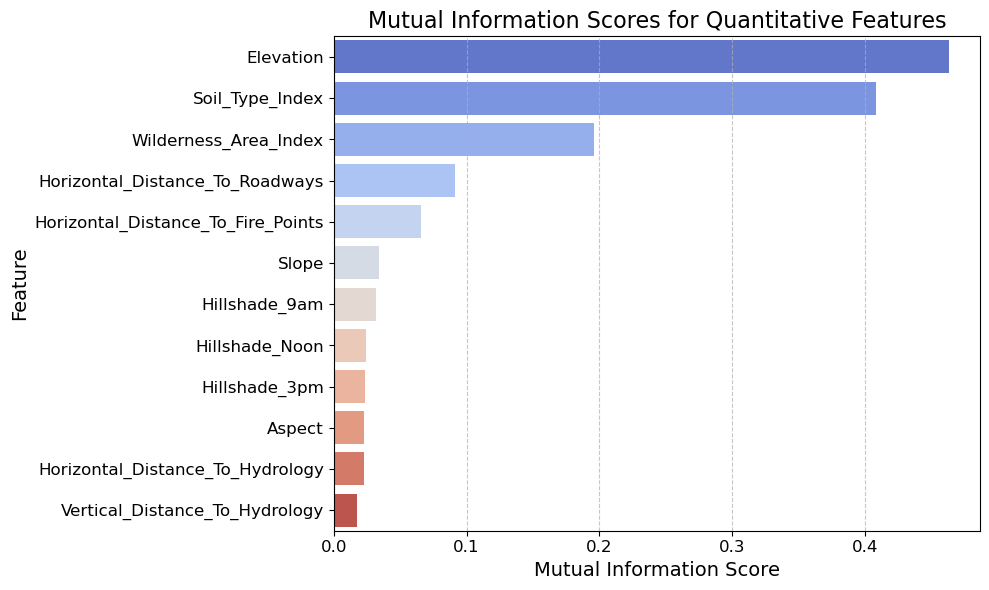

In [155]:
plot_mutual_information(data, quantitative_features, 'Cover_Type')

**Observations:**
- As expected following the univariate analysis, **Elevation, Soil_Type_Index, and Wilderness_Area_Index** have strong predictive for the **Cover Type** and following this graph we see that they are the most relevant amongs the other features.
- Other features like **Vertical_Distance_To_Hydrology** have been shown to have a small predictive power and this graph comfirms this finding.

With these insights, we can consider **two potential approaches:**
> - **Combine weakly informative features**: By merging features with lower predictive power, we can explore whether the combined feature yields more relevance for predicting the target. (see feature engineering !!!!)
> - **Dimensionality reduction techniques**: Given the patterns seen in the graph, we can apply linear methods like **PCA** or non-linear methods such as **UMAP or t-SNE** to reduce the dimensionality of the data while preserving key relationships. This may help us distill the dataset to its most informative components.

###  Chi-Square Test on Contingency Tables
Since all the quantitative features in our dataset have integer representation, we can view even the non categorical ones as categorical since we know that they are bounded and use the contingency tables to deduce if there is independance or not with the target feature using a Chi-Square Test. 
This will for example allows us to make sur if we can simply remove certain features instead of applying complex dimensionality reduction technics.

> #### Formula:
$$
\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

>Where:
>
>- $O_{ij}$ is the observed frequency in the cell at row $i$ and column $j$.
>- $E_{ij}$ is the expected frequency, which is calculated assuming independence between the two variables:
>  
$$
E_{ij} = \frac{\text{Row Total}_i \times \text{Column Total}_j}{\text{Grand Total}}
$$
>
> **Hypotheses:**
>
>- Null Hypothesis $H_0$: The two variables are independent (i.e., there is no relationship between the variables).
>- Alternative Hypothesis $H_A$: The two variables are not independent (i.e., there is a relationship).
>
> #### Interpretation:
>
>We calculate $\chi^2$ and compare it to a critical value from the chi-square distribution (with appropriate degrees of freedom).  
If the p-value is less than the significance level (usually $0.05$), we reject $H_0$.


In [94]:
from scipy.stats import chi2_contingency
import pandas as pd

def chi2_tests(data, features, target_variable):

    results = []

    for feature in features:
        contingency_table = pd.crosstab(data[feature], data[target_variable])
        chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
        results.append({'Feature': feature, 'Chi2 Stat': chi2_stat, 'P-value': p_val})
        
    chi2_results = pd.DataFrame(results)

    # Sort the results by Chi2 Stat
    chi2_results = chi2_results.sort_values(by='Chi2 Stat', ascending=False).reset_index(drop=True)

    return chi2_results

In [61]:
chi2_results = chi2_tests(data, quantitative_features, 'Cover_Type')
print(chi2_results)

                               Feature      Chi2 Stat        P-value
0                            Elevation  158118.204165   0.000000e+00
1                      Soil_Type_Index  132034.613492   0.000000e+00
2                Wilderness_Area_Index   59532.427535   0.000000e+00
3      Horizontal_Distance_To_Roadways   36855.069142   1.844887e-70
4   Horizontal_Distance_To_Fire_Points   31276.361884   9.983754e-01
5                        Hillshade_9am   10539.895131   0.000000e+00
6                                Slope    9770.458629   0.000000e+00
7                        Hillshade_3pm    8396.799182   0.000000e+00
8     Horizontal_Distance_To_Hydrology    8349.566582   0.000000e+00
9                       Hillshade_Noon    7348.018519   0.000000e+00
10      Vertical_Distance_To_Hydrology    7273.882450  2.357830e-273
11                              Aspect    6484.274792   0.000000e+00


**Observations:**
- Just by looking at the Chi-Square statististic we see that it differ slightly in ranking the moderate features (e.g., Slope), they broadly align in identifying the most and least informative features.
- That being said, we see the limitation of considering continuous values are discret since we see that the P-value corresponding to the independance of **Horizontal_Distance_To_Fire_Points** from the target value is almost 1, as in the case of continous values we expect to have high degrees of freedom by binning there values which can render the test less sensitive to actual dependencies as it requires adequate expected frequencies in each category.
- Overall we see that the same pattern as before, and that the test shows that even variables with small predictive power as aspect are not independant from the target value.

###  Linear dependency between features
We perform a correlation test to measure the strength of the linear relationship between pairs of quantitative features.

In [131]:
def plot_correlation_heatmap(X, figsize=(10, 6), cmap='viridis'):
    
    corr_matrix = X.corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, 
                cbar_kws={"shrink": 0.8, "aspect": 30}, square=True, 
                annot_kws={"size": 6, "weight": "bold"}, 
                vmin=-1, vmax=1, center=0)
    
    plt.title('Correlation Matrix of Quantitative Features', fontsize=10, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    plt.tight_layout()
    plt.show()


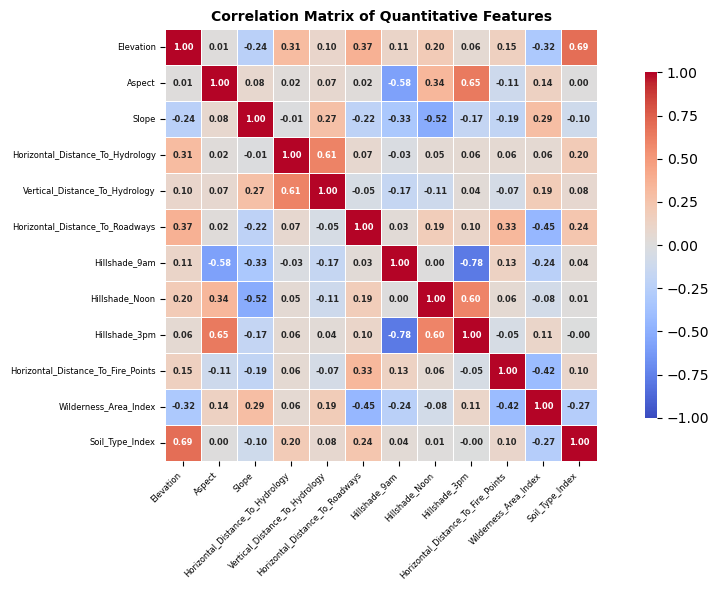

In [67]:
X = data[quantitative_features]
plot_correlation_heatmap(X, cmap="coolwarm")

**Observations:**
- Many of the feature pairs **show weak correlation** (close to 0.1). For example, **Aspect** has very low correlations with most features.
- **Horizontal_Distance_To_Hydrology** and **Vertical_Distance_To_Hydrology** (0.61): This positive correlation is expected, as both describe distances to water sources, which may often change together. (given that the first feature is more predictive than the later, we can combine them to get an even stronger signal see feature engineering !!!)
- **Hillshade_9am** and **Aspect** (-0.58): This indicates a strong negative correlation, meaning that as **Aspect** (which measures the compass direction of the slope) increases (slopes face more westward), Hillshade_9am tends to decrease (slopes face more westward). This is in particular indicative that the most forest in the data are located in the **northern hemisphere**. 

In [70]:
### Dimensionality reduction technics

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.decomposition import KernelPCA
import umap
from sklearn.model_selection import train_test_split

def plot_dimensionality_reduction(X, target, method='umap', n_components=2, sample_size=1.0, random_state=None, **kwargs):

    # Sample the data if sample_size is less than 1.0
    if sample_size < 1.0:
        X, _, target, _ = train_test_split(X, target, train_size=sample_size, random_state=random_state)
    
    # Dictionary to map method names to the actual functions
    methods = {
        'umap': lambda: umap.UMAP(n_components=n_components, **kwargs).fit_transform(X),
        'tsne': lambda: TSNE(n_components=n_components, **kwargs).fit_transform(X),
        'isomap': lambda: Isomap(n_components=n_components, **kwargs).fit_transform(X),
        'lle': lambda: LocallyLinearEmbedding(n_components=n_components, **kwargs).fit_transform(X),
        'kpca': lambda: KernelPCA(n_components=n_components, kernel=kwargs.get('kernel', 'rbf')).fit_transform(X),
    }
    
    # Ensure the method is valid
    if method not in methods:
        raise ValueError(f"Invalid method '{method}'. Choose from: 'umap', 'tsne', 'isomap', 'lle', 'kpca'.")
    
    # Apply the chosen dimensionality reduction method
    X_reduced = methods[method]()
    
    # Plot the results
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=target, palette='Set1', legend='full')
    plt.title(f'{method.upper()} Projection ({n_components}D)', fontsize=16, fontweight='bold')
    plt.xlabel(f'Component 1')
    plt.ylabel(f'Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Exploring Linear Structure with PCA

Given that the correlation matrix shows some linear relationships, PCA may capture some structure in our dataset.
Later we will introduce UMAP that is a non-linear dimensionality reduction method that is well-suited for non-linear structures.


> **Steps of the method :**
> PCA (principal component analysis) is a linear dimensionality reduction technique that transforms a dataset into a new coordinate system, with the principal components ordered by variance.
>1. **Standardize the Data**:
   $$
   z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}
   $$
>   where $z_{ij}$ is the standardized value, $\mu_j$ is the mean, and $\sigma_j$ is the standard deviation of feature $j$.

>2. **Covariance Matrix**:
   $$
   C = \frac{1}{n-1} Z^T Z
   $$
   where $Z$ is the matrix of standardized data and $n$ is the number of samples.

>3. **Eigenvalue Decomposition**:
   $$
   Cv = \lambda v
   $$
   where $v$ is the eigenvector (principal component) and $\lambda$ is the corresponding eigenvalue.

>4. **Projection**:
   $$
   Z' = ZV_k
   $$
   where $V_k$ contains the first $k$ eigenvectors and $Z'$ is the transformed data.

>5. **Explained Variance**:
   $$
   \text{Explained Variance Ratio} = \frac{\lambda_i}{\sum_{j=1}^p \lambda_j}
   $$

In [196]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_pca(X, n_components=None, scale_data=True, details=False):

    if scale_data:
        X_scaled = StandardScaler().fit_transform(X)
    else:
        X_scaled = X

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_

    print("Explained Variance by each principal component:")
    tt = 0
    for i, var in enumerate(explained_variance):
        if details :
            print(f"Principal Component {i+1}: {var:.2%}")
        tt += var

    print(f"Total variance explained: {tt:.2%}")

    return pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]), explained_variance, pca

In [198]:
X = data.drop(["Cover_Type", "Soil_Type_Index","Wilderness_Area_Index"], axis=1)
X_pca, explained_variance, _ = perform_pca(X, n_components=10, details = True)

Explained Variance by each principal component:
Principal Component 1: 7.00%
Principal Component 2: 5.53%
Principal Component 3: 4.52%
Principal Component 4: 3.77%
Principal Component 5: 2.83%
Principal Component 6: 2.61%
Principal Component 7: 2.24%
Principal Component 8: 2.14%
Principal Component 9: 2.01%
Principal Component 10: 1.98%
Total variance explained: 34.62%


**Observations:**
- We observe **low explained variance per component**. Typically for dimensionality reduction decision one would aim to capture most of the variance in the data with fewer components.
- **PCA** is inherently a linear dimensionality reduction technique. It's a good idea to explore **non-linear** dimensionality reduction methods like **t-SNE**.

In [95]:
def plot_pca_with_target(X_pca, target, component_x=1, component_y=2, title='PCA Projection', hue_name='Cover_Type'):
    plt.figure(figsize=(10, 6))
    x_col = f'PC{component_x}'
    y_col = f'PC{component_y}'
    
    sns.scatterplot(x=x_col, y=y_col, hue=target, palette='Set1', data=X_pca)
    plt.title(f'{title}: PC{component_x} vs PC{component_y}', fontsize=16, fontweight='bold')
    plt.xlabel(f'Principal Component {component_x}')
    plt.ylabel(f'Principal Component {component_y}')
    plt.legend(title=hue_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Explained Variance by each principal component:
Principal Component 1: 7.00%
Principal Component 2: 5.53%
Principal Component 3: 4.52%


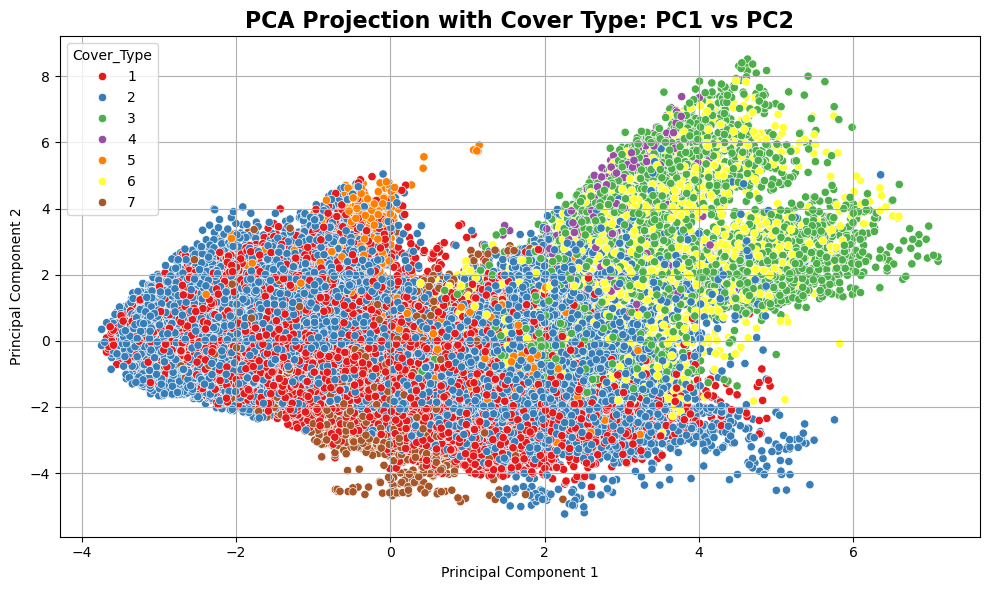

In [352]:
X_pca, explained_variance = perform_pca(X, n_components=3)

# Plot PC1 vs PC2
plot_pca_with_target(X_pca, data['Cover_Type'], component_x=1, component_y=2, title='PCA Projection with Cover Type')

**Observations:** 
- PCA is able to provide separable projections to some **cover types**, for e.g we see distinct patter for cover types **(blue, red)** and **(yellow, green)**.
- **Cover types** 5 (orange) and 7 (brown) also forms a well-defined clusters.
- The significant overlap and lack of clear separation could indicate that there are **non-linear relationships** in the data that are not being captured by this linear PCA projection.

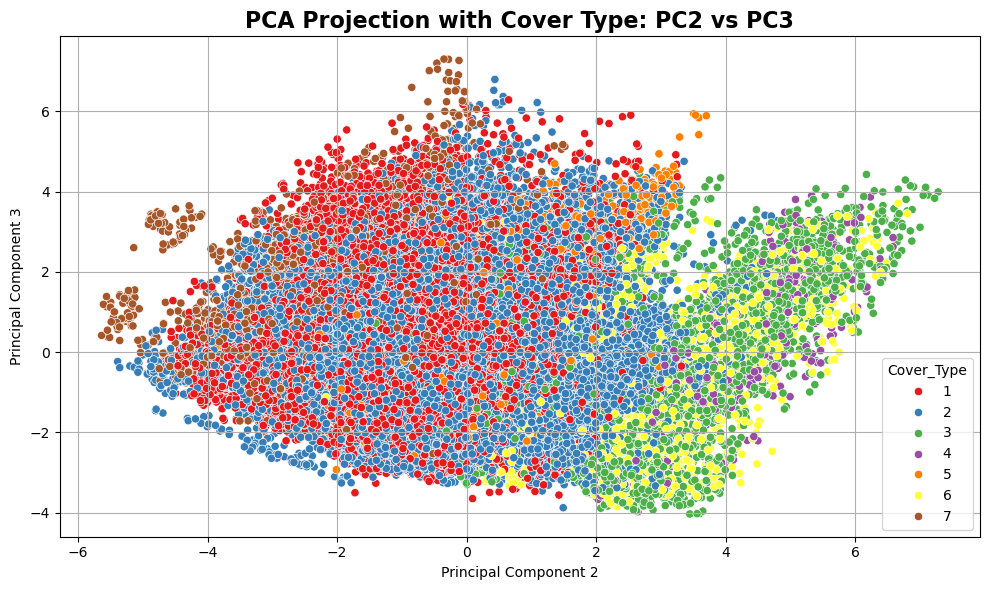

In [192]:
# Plot PC2 vs PC3
plot_pca_with_target(X_pca, data['Cover_Type'], component_x=2, component_y=3, title='PCA Projection with Cover Type')

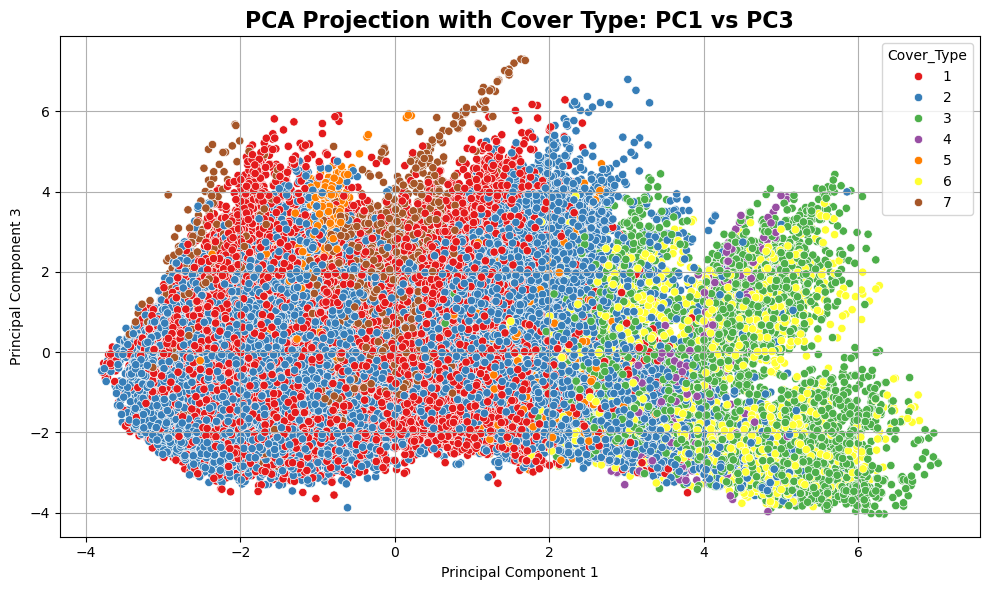

In [193]:
# Plot PC1 vs PC3
plot_pca_with_target(X_pca, data['Cover_Type'], component_x=1, component_y=3, title='PCA Projection with Cover Type')

**Observations:**
- Plotting on more principale components does not seems to change the conclusions made about projecting on the first two components. That being said, in feature engineering section, we will try a PCA inspired data to create latent variables and we aim to reduce the dimensionality of the model to account for 95% of the total variance. (see feature engineering).

#### Exploring Non-Linear Structure with t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique that projects high-dimensional data into 2D or 3D, preserving local structures in the data.

> **Steps of the method:**
>
> 1. **Calculate High-Dimensional Pairwise Similarities**:
>    In the high-dimensional space, the probability of point $x_j$ being a neighbor of $x_i$ is computed using a Gaussian distribution:
>    
>    $$
    P_{j|i} = \frac{\exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(-\frac{\|x_i - x_k\|^2}{2\sigma_i^2}\right)}
    $$
>    
>    where $\sigma_i$ controls the width of the Gaussian.
>
> 2. **Symmetric Joint Probability Distribution**:
>    The joint probability of points $x_i$ and $x_j$ being neighbors is:
>    
>    $$
    P_{ij} = \frac{P_{j|i} + P_{i|j}}{2n}
    $$
>    
>    where $n$ is the number of data points.
>
> 3. **Low-Dimensional Distribution (t-Distribution)**:
>    In the low-dimensional space, the pairwise similarity is modeled using a Student’s t-distribution:   
>    
>    $$
    Q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
    $$
>    
>    where $y_i$ and $y_j$ are the low-dimensional representations of points $x_i$ and $x_j$. The low-dimensional points $y_i$ are initialized randomly or using a method like PCA.
>
> 4. **Kullback-Leibler (KL) Divergence**:
>    t-SNE minimizes the difference between the high-dimensional and low-dimensional distributions by optimizing the KL divergence: 
>    
>    $$
    KL(P \| Q) = \sum_{i \neq j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
    $$
>
> 5. **Gradient Descent**:
>    t-SNE uses gradient descent to minimize the KL divergence:  
>    
>    $$
    \frac{\partial C}{\partial y_i} = 4 \sum_{j \neq i} (P_{ij} - Q_{ij})(y_i - y_j) \left(1 + \|y_i - y_j\|^2\right)^{-1}
    $$
>    
>    This adjusts the positions of points $y_i$ in the low-dimensional space to preserve the high-dimensional relationships.
>    
>    t-SNE refines their positions by minimizing the KL divergence. The goal is to match the distribution of pairwise distances in the low-dimensional space with the pairwise distances in the high-dimensional space $x_i$.
>
> 7. **Perplexity**:
>    Perplexity is a parameter that controls the number of neighbors considered in the high-dimensional space.


In [96]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

def apply_tsne(X, n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, 
                n_iter=n_iter, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    return X_tsne

def plot_tsne(X_tsne, target, title='t-SNE Projection with Cover Type', hue_name='Cover_Type'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=target, palette='Set1')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title=hue_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
X_tsne = apply_tsne(X, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)

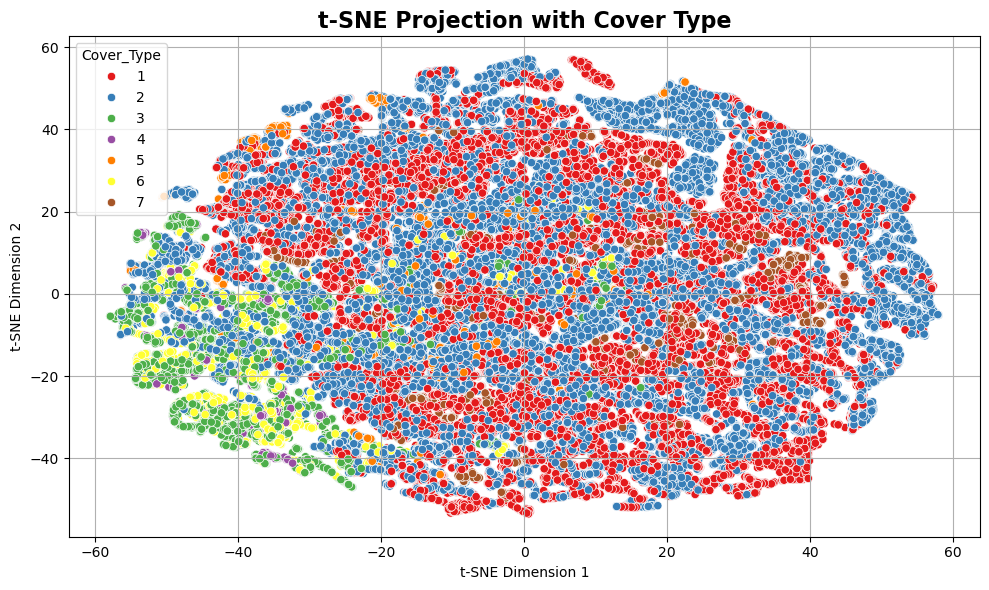

In [254]:
plot_tsne(X_tsne, data["Cover_Type"])

**Observations:**
- Similar conclusions could be made with respect to PCA analysis as we can see that the cover types $[3,6]$ (green and yellow) points are separated from cover types $[1,2]$ the blue and the red points, that being said PCA was able to better isolate cover type 7 brown points and we don't see clearly the presence of cover type 4 (purple) that PCA projections were able to be isolate.

#### Conclusion 
From the previous observations it seems that if we would like to use dimensionality reduction technic for feature engineering, pca seems to provide a good representation.

# Section 3 : Feature Engineering

## Textual features

### Extract features from textual description of soil type and from USFS Elu code

The soil type data contains a wealth of information based on USFS Ecological Landtype Units (ELUs).
Here are several features that could be extracted:
- **Soil Type Index**: A single index variable representing the soil type based on the soil type code (1 to 40), rather than maintaining the one-hot encoding.
- **Soil Complexity**: The description of the soil types often refers to how "stony" or "rubbly" the soil is, which could influence vegetation and forest cover.
- **Climate Zone**: The first digit in the soil type corresponds to the climate zone (lower montane dry, montane, subalpine, etc.). This can be extracted as a feature to understand how different climate zones impact forest cover type.
- **Geological Zone**: The second digit in the soil type corresponds to the geological zone (alluvium, glacial, igneous, etc.). This feature can provide insights into the geological formations that support certain types of forest cover.
- **Rock Outcrop Indicator**: Many of the soil types describe a rock outcrop complex (areas where rock formations are exposed). This could be an important feature, as certain tree types may prefer more exposed rocky areas.
- **Soil Wetness**: Certain soil types are associated with wet conditions (e.g., Cryaquolis, Cryaquepts, etc.), which influence the type of vegetation that thrives. This could be extracted as a feature indicating soil wetness.
- **Family Group**: We are able to group soil types based on the fact that the soil description indicates that they can share the membership of the same familly group (Cathedral familly, Ratake familly etc).

**Step1 :**
We start by defining a csv file containing soil type descprition and the corresponding elu code.

In [324]:
soil_df = pd.read_csv("data/soil_type_elu_code.csv")

In [326]:
soil_df.head()

Soil_Type_Index  USFS_ELU_Code  \
0                1           2702   
1                2           2703   
2                3           2704   
3                4           2705   
4                5           2706   

                                    Soil_Description  
0  Cathedral family - Rock outcrop complex, extre...  
1   Vanet - Ratake families complex, very stony.      
2  Haploborolis - Rock outcrop complex, rubbly.       
3  Ratake family - Rock outcrop complex, rubbly.      
4  Vanet family - Rock outcrop complex complex, r...

**Step2** : 
We define procedures to extract relevant informations from the soil csv file

In [329]:
def extract_stoniness(description):
    description = description.lower()
    if 'extremely stony' in description:
        return 4
    elif 'very stony' in description:
        return 3
    elif 'stony' in description:
        return 2
    elif 'rubbly' in description:
        return 1
    else:
        return 0

def extract_climate_zone(elu_code):
    return int(str(elu_code)[0])

def extract_geological_zone(elu_code):
    return int(str(elu_code)[1])

def extract_rockiness(description):
    description = description.lower()
    if 'rock outcrop' in description :
        return 1
    elif 'rock land' in description :
        return 2
    else :
        return 0

def extract_wetness(description):
    description = description.lower()
    return 1 if 'wet' in description or 'aquo' in description else 0

def determine_fertility(description):
    description = description.lower()
    if 'aquolis' in description:
        return 2
    elif 'rubbly' in description or 'rock land' in description:
        return 0
    else:
        return 1

# Apply the extraction functions to the soil_df DataFrame
soil_df['Soil_Stoniness'] = soil_df['Soil_Description'].apply(extract_stoniness)
soil_df['Climate_Zone'] = soil_df['USFS_ELU_Code'].apply(extract_climate_zone)
soil_df['Geological_Zone'] = soil_df['USFS_ELU_Code'].apply(extract_geological_zone)
soil_df['Rock_Outcrop'] = soil_df['Soil_Description'].apply(extract_rockiness)
soil_df['Soil_Wetness'] = soil_df['Soil_Description'].apply(extract_wetness)
soil_df['Soil_Fertility'] = soil_df['Soil_Description'].apply(determine_fertility)

In [331]:
import re

# Function to extract family names from description
def extract_family(description):
    description = description.lower()
    match = re.search(r'([A-Za-z]+) famil', description)
    if match:
        return match.group(1)
    return None

# Create a dictionary to map families to soil type indices
soil_type_famillies = {}
i = 0

for desc in soil_df["Soil_Description"]:
    if extract_family(desc) is not None :
        family_name = extract_family(desc)
        if family_name not in soil_type_famillies:
            soil_type_famillies[extract_family(desc)] = i
            i+= 1
            
soil_type_famillies["other"] = len(soil_type_famillies)
soil_type_family_group = []
for desc in soil_df["Soil_Description"]:
    if extract_family(desc) is not None :
        family_name = extract_family(desc)
    else :
        family_name = "other"
    soil_type_family_group.append(soil_type_famillies[family_name])

soil_df["Family_Group"] = soil_type_family_group

Worth mentionning that some cover types are members of **two famillies** and we only consider the later for the attribution, **see example below** :

In [334]:
extract_family("Leighcan - Catamount families - Rock outcrop complex, extremely stony.")

'catamount'

In [335]:
soil_df.head()

Soil_Type_Index  USFS_ELU_Code  \
0                1           2702   
1                2           2703   
2                3           2704   
3                4           2705   
4                5           2706   

                                    Soil_Description  Soil_Stoniness  \
0  Cathedral family - Rock outcrop complex, extre...               4   
1   Vanet - Ratake families complex, very stony.                   3   
2  Haploborolis - Rock outcrop complex, rubbly.                    1   
3  Ratake family - Rock outcrop complex, rubbly.                   1   
4  Vanet family - Rock outcrop complex complex, r...               1   

   Climate_Zone  Geological_Zone  Rock_Outcrop  Soil_Wetness  Soil_Fertility  \
0             2                7             1             0               1   
1             2                7             0             0               1   
2             2                7             1             0               0   
3             2                7             1             0               0   
4             2                7             1             0               0   

   Family_Group  
0             0  
1             1  
2            15  
3             1  
4             2

In [338]:
# Drop the description columns
soil_df = soil_df.drop(['USFS_ELU_Code', 'Soil_Description'], axis=1)

**step 3** : 
the dataset could be augmented by these features by doing an inner join on the soil type index

## Non ordinal categorical features
### One-hot encoding
Some classification models like **logistic regression, SVM, and k-nearest neighbors** might suffer if we only represent non-ordinal categorical features using integer encoding, as it introduces false ordinal relationships. 
For such models, one hot-encoding these features is a good solution.

On the other hand, **Tree-based classification models** like Decision Trees and Random Forests **don’t rely on feature scaling or linear relationships**, so using integer encoding might not necessarily hurt the model's performance.

In [342]:
def ordinal_one_hot_encoding(data):
    ordinal_columns = ['Soil_Stoniness', 
                       'Climate_Zone', 'Geological_Zone', 'Rock_Outcrop', 
                       'Soil_Wetness', 'Soil_Fertility', 'Family_Group']

    res = pd.get_dummies(data, columns=ordinal_columns, drop_first=True, dtype='int')
    return res

### Embedding layer

Adding embedding layer for categorical variables is an alternative to one-hot encoding. The embedding layer allows the model to learn a dense, continuous representation of categorical data, which is more efficient than one-hot encoding, especially when there are many categories.
We will use this method for a **deep learning model**.

## Quantitative features

As seen in univariate analysis and also based on the mutual information plot we propose to combines the **Vertical_Distance_To_Hydrology** and **Horizontal_Distance_To_Hydrology** with the aim of getting a stronger predictor of the **Cover_Type**, which is a non linear transformation of these two features.

In [346]:
def combine_distance_features(df):
    df['Distance_To_Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)
    return df

def combine_hillshade_features(df):
    df['Average_Hillshade'] = (df['Hillshade_9am'] + df['Hillshade_Noon'] + df['Hillshade_3pm'])/3.0
    return df

# Latent variables

After one-hot encoding all the categorical features in the data, the number of columns may significantly increase, resulting in a **high-dimensional and sparse dataset**. This increased dimensionality can lead to longer model training times and potentially cause overfitting due to the sparsity. Moreover, much of the relevant information might still be represented in a **lower-dimensional space**, motivating the use of **latent variables**.

**Latent variables** are transformations of the original features into a reduced number of dimensions while preserving as much important information as possible. This dimensionality reduction makes the model training more efficient and can help avoid issues like overfitting.

For linear relationships between the features, **PCA** (presented above) can be used to generate latent variables. PCA creates linear combinations of the original features, capturing the most variance in the data. For non-linear patterns, a more flexible approach such as **autoencoders**, can be employed. Autoencoders are neural networks that learn non-linear transformations, reducing the dimensionality of the dataset while preserving the structure and relationships in a more complex way.

In the next section we present both methods that we will try to use later for the model training.

### Linear variables

In [171]:
# using PCA
from sklearn.decomposition import PCA

def generate_pca_features(X, n_components=5):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

### Non linear variables

In [174]:
# using an auto-encoder
import torch
import torch.nn as nn
import torch.optim as optim

# Define the autoencoder architecture using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Assuming the input features are normalized between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to train the autoencoder
def train_autoencoder(model, data, epochs=50, batch_size=256, learning_rate=1e-3):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader for mini-batch training
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        for batch in data_loader:
            # Forward pass
            output = model(batch)
            loss = criterion(output, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Section 4 : Modeling

## Model Selection

For handling imbalanced datasets, selecting models that can address the imbalance is key to improving both predictive performance and robustness across all classes.

### Logistic Regression for Classification

Logistic Regression is a linear model that uses a logistic (sigmoid) function to map the output of a linear model to probabilities for classification.

#### Prediction Function:
For binary classification, the logistic function produces the probability that the input belongs to class 1:

$$
p(y = 1 \mid X) = \frac{1}{1 + e^{-(\theta_0 + \theta^T X)}}
$$

For multi-class classification, this extends to a softmax function for each class $c$:

$$
p(y = c \mid X) = \frac{e^{\theta_c^T X}}{\sum_{c'} e^{\theta_{c'}^T X}}
$$

Where:
- $\theta_c$ are the parameters for class $c$.
- $\sum_{c'}$ runs over all possible classes.

#### Training Objective:
Logistic regression minimizes the negative log-likelihood (or equivalently, the cross-entropy loss) for binary classification:

$$
\mathcal{L}(\theta) = - \sum_{i=1}^{n} \left( Y_i \log p(Y_i \mid X_i) + (1 - Y_i) \log (1 - p(Y_i \mid X_i)) \right)
$$

For multi-class classification, the loss becomes:

$$
\mathcal{L}(\theta) = - \sum_{i=1}^{n} \sum_{c=1}^{C} \mathbf{1}\{Y_i = c\} \log p(Y_i = c \mid X_i)
$$

Where $C$ is the number of classes.

#### Why is it effective:

Logistic regression is a simple linear model, and can perform well on unbalanced datasets using `class_weight='balanced'`to address class imbalance. 

**However, it may struggle with non-linear data, so we will useful more as a benchmark.**

### Classification Trees

Classification trees are non-linear models that partition the feature space into regions associated with different classes. The model works by recursively splitting the data based on feature values that best separate the target classes, resulting in a tree structure where each leaf represents a predicted class.

### Why is it effective:
Classification trees are intuitive and handle non-linear relationships and interactions between features naturally, making them effective for complex datasets with structured patterns. They are also robust to irrelevant features, as unhelpful features are less likely to be chosen as split points. Trees can also handle both numerical and categorical data without requiring extensive preprocessing.

However, individual trees can be prone to overfitting, especially with deep trees. Ensemble methods, such as **Random Forests or Gradient Boosted Trees**, often improve upon single-tree performance by reducing variance. In this case, we will use single trees as a benchmark for comparison with more advanced models.



### Random Forest Classifier

The Random Forest classification model consists of an ensemble of decision trees, where each tree is trained on a subset of the data with a random feature selection at each split in the decision tree. The final prediction is based on a majority vote of the trees' predictions.

#### Prediction Function:
For an input $X$, the final predicted class $\hat{y}$ is determined by majority voting among $K$ trees:

$$
\hat{y} = \text{argmax}_c \sum_{k=1}^{K} \mathbf{1}\{ h_k(X) = c \}
$$

Where:
- $K$ is the number of trees in the forest.
- $h_k(X)$ is the prediction of the $k^{th}$ tree for input $X$.
- $\mathbf{1}\{ h_k(X) = c \}$ is the indicator function that counts how many trees predicted class $c$.

#### Training Objective:
Each tree is trained using the Gini impurity criterion:

$$
G = \sum_{i=1}^{C} p_i (1 - p_i)
$$

Where:
- $p_i$ is the proportion of class $i$ at a node.
- $C$ is the total number of classes.

#### Why it's effective: 

Random Forest is an ensemble model that can be robust to class imbalance by averaging the results of multiple decision trees, reducing variance, and preventing overfitting. It can handle imbalance by adjusting class weights. Setting class weights inversely proportional to class frequencies (via `class_weight="balanced"` in scikit-learn). This helps to ensure that the minority classes get more focus during training.

**Note**: There is also a special implementation of this model in `Imbalanced-learn` library called Balanced Random Forest (BRF) where at each iteration, a balanced bootstrap sample (equal number of samples from each class) is used to train each decision tree. Where are going to test this implementation also.

### Gradient Boosting Classifier : XGBoost

Gradient Boosting is an iterative ensemble method that builds a sequence of decision trees $f_m^c(X)$, where each new tree corrects the errors made by the previous trees.
In XGBoost for **multi-class classification**, $F^c(X)$ represents the ensemble prediction for class $c$. The model build iteratively this final prediction function using intermediary predictors $F_m^c(X)$.

#### Prediction function
After all trees are added, the final prediction for class $c$ is:
$$
F^c(X) = F_0^c(X) + \eta \sum_{m=1}^{M} f_m^c(X)
$$

Where:
- $F_m^c(X)$ is the prediction after the $m^{th}$ tree for class $c$,
- $f_m^c(X)$ is the $m^{th}$ tree’s prediction for class $c$,
- $\eta$ is the learning rate.

To convert the ensemble predictions into class probabilities, XGBoost applies the **softmax function**:
$$
p(y = c \mid X) = \frac{e^{F_c(X)}}{\sum_{c'} e^{F_{c'}(X)}}
$$
This ensures that the output probabilities sum to 1 across all classes.

#### Objective Function
At each step, XGBoost minimizes an objective function composed of two parts:
- **Loss function**: XGBoost uses **softmax cross-entropy loss** for multi-class classification.
- **Regularization**: Penalizes complexity to avoid overfitting.

At iteration $m$, the objective function is:
$$
L(m) = \sum_{i=1}^{n} \sum_{c=1}^{C} l(y_i^c, F_{m-1}^c(X_i) + f_m^c(X_i)) + \Omega(f_m)
$$
Where $l(y_i^c, F^c(X_i))$ is the cross-entropy loss for class $c$, and $\Omega(f_m)$ is the regularization term for tree complexity.

#### Tree Construction with Gradient and Hessian
Each tree is constructed by greedily choosing splits that minimize the objective function. At each node, XGBoost evaluates candidate splits using both the gradient and Hessian to decide the best split.

For each potential split, the model computes the **gain** (improvement in the objective) as:
$$
\text{Gain} = \frac{1}{2} \left( \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right) - \gamma
$$
Where:
- $G_L$, $H_L$: Gradient and Hessian sums for the left split.
- $G_R$, $H_R$: Gradient and Hessian sums for the right split.
- $\lambda$: L2 regularization term (smooths leaf weights).
- $\gamma$: Penalty for adding a new leaf (controls tree size).

This greedy approach ensures that each new tree maximally reduces the residual error.

#### Regularization
XGBoost applies both L1 and L2 regularization to control overfitting and tree complexity:
$$
\Omega(f_m) = \gamma T_m + \frac{1}{2} \lambda \sum_{j=1}^{T_m} w_j^2
$$
Where:
- $T_m$ is the number of leaves in the tree,
- $w_j$ is the weight of leaf $j$,
- $\gamma$ controls the penalty for adding more leaves,
- $\lambda$ is the L2 regularization coefficient.

#### Why it's effective
Its gradient boosting process emphasizes difficult-to-classify examples, often from the minority class making it a good choice for our case. Also
XGBoost is highly effective for handling imbalanced datasets due to its ability to adjust class importance through `scale_pos_weight` parameter, giving more focus to the minority class. L1 and L2 regularization controls overfitting, and its tree pruning technique prevents overfitting to the majority class while maintaining sufficient depth to handle minority examples.

### AdaBoost Classifier

AdaBoost, short for Adaptive Boosting, is an ensemble method that combines multiple weak classifiers to create a strong classifier. It works by sequentially training a series of weak classifiers, typically decision stumps (shallow decision trees), with each classifier focusing on the errors made by the previous one. AdaBoost adjusts the weights of incorrectly classified instances, giving more focus to hard-to-classify cases.

#### Prediction Function:
For a given input $X$, the final prediction is a weighted vote of all weak classifiers $h_m(X)$:

$$
\hat{y} = \text{sign} \left( \sum_{m=1}^{M} \alpha_m h_m(X) \right)
$$

Where:
- $M$ is the number of weak classifiers,
- $h_m(X)$ is the prediction of the $m$-th weak classifier (typically $h_m(X) \in \{-1, +1\}$ for binary classification),
- $\alpha_m$ is the weight assigned to the $m$-th classifier based on its accuracy.

#### Training Objective:
AdaBoost minimizes the exponential loss function, which increases the penalty for misclassified examples. During each iteration $m$, AdaBoost adjusts the weights of the training samples based on whether they were correctly or incorrectly classified by the previous classifier.

1. **Initialize Weights**: Start with equal weights for all $n$ training samples:

   $$
   w_i^{(1)} = \frac{1}{n}, \quad i = 1, 2, \dots, n
   $$

2. **Compute Classifier Error**: For each weak classifier $h_m$, compute the weighted error:

   $$
   \epsilon_m = \sum_{i=1}^{n} w_i^{(m)} \mathbf{1}\{h_m(X_i) \neq y_i\}
   $$

   where $\mathbf{1}\{h_m(X_i) \neq y_i\}$ is an indicator function that equals 1 if $h_m(X_i)$ misclassifies $X_i$, and 0 otherwise.

3. **Compute Classifier Weight**: The weight of each classifier $\alpha_m$ is based on its error $\epsilon_m$:

   $$
   \alpha_m = \frac{1}{2} \log \left( \frac{1 - \epsilon_m}{\epsilon_m} \right)
   $$

   Classifiers with lower errors receive higher weights, making them more influential in the final prediction.

4. **Update Sample Weights**: Update the weights of each training sample for the next iteration $m+1$:

   $$
   w_i^{(m+1)} = w_i^{(m)} \exp(-\alpha_m y_i h_m(X_i))
   $$

   Normalize $w_i^{(m+1)}$ so that the weights sum to 1. Misclassified samples receive higher weights, while correctly classified samples receive lower weights, focusing the next classifier on harder cases.

#### Why it’s Effective:

AdaBoost is effective in handling complex datasets by iteratively focusing on hard-to-classify examples, which helps to improve the model's accuracy. It is less prone to overfitting than individual weak classifiers, as it combines the strengths of multiple models, and it can handle class imbalance to some extent by prioritizing misclassified instances. However, AdaBoost can be sensitive to noisy data and outliers since it increases weights on samples that are difficult to classify.

**Note**: AdaBoost can be used for multiclass classification by applying the SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function) algorithm, an extension of AdaBoost for multi-class problems.
, an extension of AdaBoost for multi-class problems.


### CatBoost Classifier

CatBoost (Categorical Boosting) is a gradient boosting algorithm that is specifically optimized to handle categorical features and reduce overfitting. It builds an ensemble of decision trees sequentially, where each tree corrects the errors made by the previous ones, using gradient boosting on decision trees as its core technique. CatBoost is particularly efficient with categorical data and is designed to be less prone to overfitting through the use of ordered boosting.

#### Prediction Function:
For a given input $X$, the final prediction for class $c$ is obtained by summing the contributions from all trees in the ensemble:

$$
F^c(X) = F_0^c(X) + \eta \sum_{m=1}^{M} f_m^c(X)
$$

Where:
- $M$ is the total number of trees in the ensemble,
- $F_0^c(X)$ is the initial prediction (often the average prediction over the training data),
- $f_m^c(X)$ is the prediction from the $m$-th tree for class $c$,
- $\eta$ is the learning rate that scales each tree's contribution.

To convert the predictions into probabilities, CatBoost applies the **softmax function** for multi-class classification:

$$
p(y = c \mid X) = \frac{e^{F^c(X)}}{\sum_{c'} e^{F^{c'}(X)}}
$$

This function ensures that the output probabilities across all classes sum to 1.

#### Objective Function:
At each iteration, CatBoost minimizes a regularized objective function, which includes:
- **Loss Function**: CatBoost typically uses **log loss** (cross-entropy) for multi-class classification.
- **Regularization Term**: Helps control model complexity and prevent overfitting.

For each class $c$ at iteration $m$, the objective function is:

$$
L(m) = \sum_{i=1}^{n} \sum_{c=1}^{C} l(y_i^c, F_{m-1}^c(X_i) + f_m^c(X_i)) + \Omega(f_m)
$$

Where:
- $l(y_i^c, F^c(X_i))$ is the cross-entropy loss for class $c$,
- $\Omega(f_m)$ is the regularization term for controlling the complexity of the trees.

#### Handling Categorical Features
CatBoost handles categorical features using **ordered boosting** and **target-based statistics**. Instead of relying on one-hot encoding, which can be inefficient, CatBoost uses:
- **Ordered Target Statistics**: Applies statistics based on target values, such as mean encoding, for categorical features while ensuring data leakage prevention.
- **Ordered Boosting**: Ensures that each tree is built in a way that avoids target leakage, as it only uses past observations when calculating statistics for categorical features.

#### Why it’s Effective:

CatBoost is particularly effective for datasets with many categorical features due to its efficient handling of categorical data and built-in prevention of data leakage through ordered boosting. It also has strong generalization capabilities, as it applies robust regularization techniques to control overfitting. This makes CatBoost highly suitable for high-dimensional datasets with mixed feature types. Additionally, CatBoost can handle class imbalance by adjusting the class weights or using techniques like the `scale_pos_weight` parameter, which increases the importance of the minority class.

**Note**: CatBoost can be used for both binary and multi-class classification tasks, and it is known for its fast training speed, even with large datasets.


### Ensemble Learning 
#### EasyEnsemble
To address data imbalance and reduce the model's tendency to overfit on the majority class, we employ an EasyEnsemble model. This approach involves generating multiple balanced datasets through random undersampling of the majority class and adjusting the ratios between the majority and minority classes. Each balanced dataset is then used to train a classifier, and the final predictions are made by aggregating the outputs of all the models. In this case, we utilize the `EasyEnsembleClassifier` from the `imbalanced-learn` library.

This algorithm is known as EasyEnsemble. The classifier is an ensemble of AdaBoost learners trained on different balanced bootstrap samples. The balancing is achieved by random under-sampling.

#### Why it's effective:
The method is designed for high generalization performance, combining the benefits of both undersampling and ensemble learning.n imbalanced data.



#### Personalized Ensemble with Custom Ratios (EasyEnsemble Adaptation)

This personalized ensemble method addresses class imbalance by creating multiple customized datasets with varied ratios of majority-to-minority samples. The function `create_dataset_with_ratio` generates datasets that include all minority class samples while selectively downsampling the majority class based on a specified `majority_ratio`. This targeted downsampling allows each dataset to retain all minority examples while balancing the influence of the majority class, preserving diverse perspectives across datasets.

#### Key Steps:

1. **Dataset Creation with Custom Ratios**: 
   Each dataset contains all minority class samples alongside a subset of majority class samples determined by the specified `majority_ratio`. This selective inclusion helps maintain minority class representation while adjusting the influence of the majority class in each dataset.

2. **Multiple Balanced Datasets**:
   By iterating through different `majority_ratios`, this approach creates datasets that vary from nearly balanced to more imbalanced. This variation allows the model to view multiple perspectives of the data distribution, enhancing its generalization ability.

3. **Enhanced Focus on Minority Class**:
   Since all datasets include the complete set of minority samples but only partial majority samples, models trained on these datasets tend to better capture minority class patterns, which reduces the class imbalance effect.

4. **Ensemble Benefit**:
   Training an ensemble across these curated datasets allows the final model to aggregate strengths from multiple classifiers, each focused on learning from a different data balance. This increases the accuracy of minority class predictions, often outperforming a single model trained on an imbalanced dataset.

#### Why It’s Effective:
This approach systematically enhances the focus on the minority class by combining selective sampling with ensemble learning. It helps improve the predictive accuracy for minority samples while retaining diverse majority class information, producing a balanced model with improved performance on imbalanced data.



### Specialized Loss functions

#### Cost-Sensitive Learning
Cost-sensitive learning explicitly accounts for the different costs of misclassifying each class. This is crucial in imbalanced datasets, where errors in minority classes should carry a higher penalty than those in majority classes. By assigning higher costs to misclassifications of minority classes, the model focuses more on correctly predicting these underrepresented instances.

Implementation: Cost-sensitive learning can be applied to models like Random Forest, Gradient Boosting, and Logistic Regression by assigning class-specific penalties in the learning process.

#### Focal Loss
Focal loss is a specialized loss function designed to make the model focus more on hard-to-classify minority instances. It dynamically scales the standard cross-entropy loss, giving more weight to misclassified examples, especially those from the minority class.

**Focal loss** is designed to down-weight the contribution of easy-to-classify samples, placing more focus on hard-to-classify examples, which is particularly useful for imbalanced datasets. The focal loss function modifies the standard cross-entropy loss as follows:

$$
\text{FL}(p_t) = -\alpha (1 - p_t)^\gamma \log(p_t)
$$

Where:
- $p_t$ is the model's estimated probability for the true class,
- $\alpha$ is a weighting factor that balances the importance of different classes,
- $\gamma$ (the focusing parameter) controls the strength of down-weighting for well-classified examples.

By using focal loss, the MLP focuses on learning the minority class samples more effectively, which can lead to better performance on imbalanced data.

#### Why These Methods Are Effective
Cost-sensitive learning and focal loss enhance the model’s performance by addressing the core issue of imbalanced datasets: the disproportionate impact of errors in minority classes. These approaches allow the model to optimize for both minority and majority classes without the need for resampling techniques, which can distort the dataset.

# Section 5 : Model training

## Logistic Regression for Classification
### standard implementation using class weighting
#### Training Approach

- **Feature Engineering**:  
  To ensure model convergence, we will apply feature engineering, including data scaling. For categorical features, we will use one-hot encoding, as logistic regression can be sensitive to the ordinal nature of classes.

- **Dimensionality Reduction**:  
  Since logistic regression is linear and one-hot encoding increases feature sparsity and dimensionality, we introduce latent variables by will ingapply Principal Component Anal PCA), a linear transform dreadye already knowingespit from previous  wing that the data exhibits non-linearern, soattwe expect that we will need to retain a high number of principal compo to keep the information in the data.eTts, that being said we are able to reduce the dimensionality of the data to half while retaining 98% of the int ests.

- **Data Scaling**:  
  Logistic regression requires scaled data for optimal convergence, so we will ensure all features are appropriately scaled.

- **Class Weighting**:  
  To address class imbalance, we will use the `class_weight='balanced'` parameter, which automatically adjusts class weights inversely proportional to class frequencies. This ensures the model pays more attention to minorty classes.


In [190]:
# Apply textual and quantitative feature engineering and one-hot encoding for non ordinal categorical features
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)
engineered_data = engineered_data.drop(columns = ["Soil_Type_Index", "Wilderness_Area_Index"])
engineered_data = ordinal_one_hot_encoding(engineered_data)

# Data preparation
X = engineered_data.drop('Cover_Type', axis=1)
y = engineered_data['Cover_Type']

In [192]:
engineered_data.shape

(100000, 90)

In [200]:
# Apply PCA to reduce the dimensionality of the dataset, we keep pca_model trained on the dataset for the evaluation step
X, _, pca_model = perform_pca(X, 45, details = False)

Explained Variance by each principal component:
Total variance explained: 97.82%


**Comment:** We have reduced the dimensionality of the dataset by half while keeping more than 98% of the inertie.

In [202]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [204]:
# Fit Logistic Regression on the reduced training data
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1, solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

# Predict the class with the highest probability for multiclass classification
y_pred = lr_model.predict(X_test_scaled)

# Evaluate the Model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.66      0.67      7282
           2       0.79      0.52      0.63      9735
           3       0.69      0.52      0.59      1255
           4       0.26      0.84      0.39        94
           5       0.11      0.82      0.19       327
           6       0.32      0.65      0.43       593
           7       0.41      0.89      0.56       714

    accuracy                           0.59     20000
   macro avg       0.46      0.70      0.49     20000
weighted avg       0.70      0.59      0.62     20000

Confusion Matrix:
[[4805 1263    2    0  310   46  856]
 [2214 5056  152    3 1834  403   73]
 [   0    6  657  173   60  359    0]
 [   0    0   10   79    0    5    0]
 [   0   47    4    0  267    9    0]
 [   0    4  130   53   20  386    0]
 [  75    0    0    0    1    0  638]]


#### Conclusion

As anticipated, logistic regression did not perform well in classifying the dataset. This is due to the fact that the data exhibits non-linear patterns, as highlighted in our earlier analysis. Since logistic regression is inherently a linear model, it struggles to capture the underlying complexities of the data. In the next section, we will explore non-linear models that are better suited to handle the dataset’s structure and should improve classification performaenc.


## Decision Tree Classifier
### Standard Implementation
#### Training Approach
- **Non-linear Pattern Handling**: The decision tree model is adept at capturing the dataset’s non-linear structure, addressing the limitations encountered with logistic regression’s linear assumptions.
- **Flexible Decision Boundaries**: By creating flexible, non-linear decision boundaries, the decision tree can better partition the feature space and improve classification accuracy on complex data.
- **Goal**: This approach aims to enhance interpretability and model performance by utilizing a classifier that aligns with the data’s underlying complexity.

In [230]:
# Apply textual and quantitative feature engineering and one-hot encoding for non ordinal categorical features
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)
engineered_data = engineered_data.drop(columns = ["Soil_Type_Index", "Wilderness_Area_Index"])
engineered_data = ordinal_one_hot_encoding(engineered_data)

# Data preparation
X = engineered_data.drop('Cover_Type', axis=1)
y = engineered_data['Cover_Type']

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Fit the model
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt_model.predict(X_test)
print("Classification Report (Decision Tree):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix (Decision Tree):")
print(confusion_matrix(y_test, y_pred))

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           1     0.8554    0.8644    0.8599      7243
           2     0.8832    0.8800    0.8816      9810
           3     0.8385    0.8561    0.8472      1237
           4     0.6795    0.6883    0.6839        77
           5     0.6522    0.6344    0.6432       331
           6     0.7483    0.7011    0.7239       619
           7     0.8673    0.8419    0.8544       683

    accuracy                         0.8612     20000
   macro avg     0.7892    0.7809    0.7849     20000
weighted avg     0.8610    0.8612    0.8611     20000

Confusion Matrix (Decision Tree):
[[6261  892    2    0   14    2   72]
 [ 948 8633   70    0   86   57   16]
 [   2   69 1059   22    5   80    0]
 [   0    1   18   53    0    5    0]
 [  18   93    8    0  210    2    0]
 [   1   69  106    3    6  434    0]
 [  89   18    0    0    1    0  575]]


**Observation:** As expected, this model is better at capturing the underlying patterns, which, as shown in our preliminary analysis, are non-linear. Decision trees also offer interpretability, allowing us to understand the decision-making process through clear, rule-based splits. Based on these strengths, we focus our analysis on tree-based models, which are well-suited for non-linear relationships. To further enhance model performance, we will employ advanced techniques such as boosting and bagging.

## Random Forest

### Standard Implementation (using class weight)
#### Training Approach
- **Random Forest Feature Importance**: A Random Forest model was employed to compute feature importance, helping to identify the most influential features that contributed to the model's performance.
- **Feature Reduction**: Using the feature importance scores, we reduced the number of features to focus solely on the most predictive ones, improving the model’s efficiency and performance.
- **Goal**: The reduction in features aimed to minimize model uncertainty, enhance generalization, and reduce overfitting by removing less useful features.

In [233]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

**Initial Feature Engineering testing**

In [236]:
# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on = "Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

In [238]:
updated_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type_Index',
       'Wilderness_Area_Index', 'Soil_Stoniness', 'Climate_Zone',
       'Geological_Zone', 'Rock_Outcrop', 'Soil_Wetness', 'Soil_Fertility',
       'Family_Group', 'Distance_To_Hydrology', 'Average_Hillshade']

Elevation                             0.464807
Soil_Type_Index                       0.407406
Climate_Zone                          0.324892
Family_Group                          0.285353
Soil_Stoniness                        0.198739
Wilderness_Area_Index                 0.191870
Rock_Outcrop                          0.093742
Soil_Fertility                        0.091793
Horizontal_Distance_To_Roadways       0.090660
Horizontal_Distance_To_Fire_Points    0.067579
Geological_Zone                       0.054629
Distance_To_Hydrology                 0.051902
Slope                                 0.037188
Hillshade_9am                         0.030964
Horizontal_Distance_To_Hydrology      0.026286
Hillshade_3pm                         0.023084
Hillshade_Noon                        0.021570
Average_Hillshade                     0.020234
Aspect                                0.019486
Soil_Wetness                          0.019267
Vertical_Distance_To_Hydrology        0.017524
dtype: float6

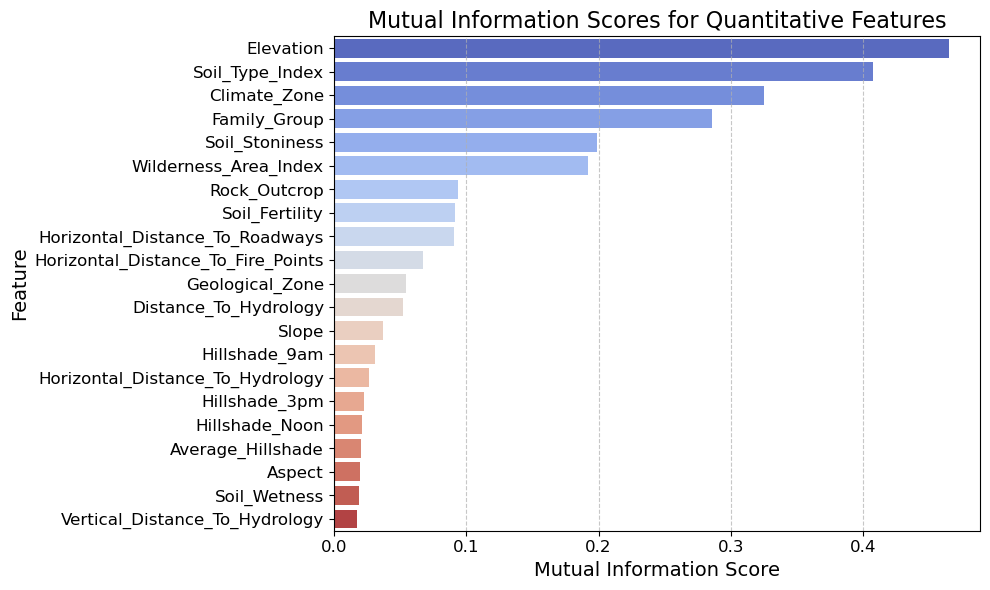

In [240]:
plot_mutual_information(engineered_data, updated_features,"Cover_Type")

**Observation**: The feature engineering process resulted in the creation of more predictive features for determining the cover type. 
Based on an initial test of feature importance using a Random Forest model on the full dataset including the one-hot encoded vectors for soil type and wildernes area columns initially provided in the dataset, we measured the importance of all features and subsequently reduced the number of features to focus on the most predictive ones *(see below the list of columns to drop)*. This reduction was aimed at **decreasing model uncertainty and enhancing performance**.


In [242]:
# remove non important features to reduce the model uncertainty
columns_to_drop = ['Cover_Type','Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop','Slope', 'Hillshade_Noon', 'Hillshade_3pm',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade']

# data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type']

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [243]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight

# Train Random Forest with class weights
rf_model = RandomForestClassifier(class_weight="balanced", random_state=1, n_estimators=110, n_jobs=-1)

# Fit the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1     0.9327    0.9055    0.9189      7282
           2     0.9167    0.9512    0.9337      9735
           3     0.8954    0.9275    0.9112      1255
           4     0.8778    0.8404    0.8587        94
           5     0.8770    0.6544    0.7496       327
           6     0.8811    0.7875    0.8317       593
           7     0.9564    0.8908    0.9224       714

    accuracy                         0.9207     20000
   macro avg     0.9053    0.8511    0.8752     20000
weighted avg     0.9207    0.9207    0.9201     20000

Confusion Matrix:
[[6594  651    0    0    7    2   28]
 [ 400 9260   33    1   21   19    1]
 [   0   41 1164    8    2   40    0]
 [   0    0   15   79    0    0    0]
 [   6  102    3    0  214    2    0]
 [   0   39   85    2    0  467    0]
 [  70    8    0    0    0    0  636]]


**Conclusion:** With a weighted f1-score of 92%, the Random Forest model shows strong classification performance, particularly with high precision and recall for the dominant classes. However, it exhibits lower recall on classes 5 and 6, which is an area for potential improvement. To address this, the next step will be to implement a balanced dataset approach to reduce bias towards the majority classes. Specifically, we will explore the Balanced Random Forest implementation to assess whether this improves performance on the minority classes.


### Balanced Random Forest using `Imbalanced-learn` implementation
#### Training Approach
- **Approach**:  To address the class imbalance, we used a Balanced Random Forest (BRF), which combines the standard Random Forest approach with a resampling technique to balance the dataset.
   - The `sampling_strategy='all'` balances each class by resampling the minority classes
   - `replacement=True` allows for oversampling of minority classes with replacement
   - `bootstrap=False` disables standard bootstrapping in favor of balanced samples

In [320]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Example of adjusting class weights
brf_model = BalancedRandomForestClassifier(random_state=1, 
                                           n_estimators=110, 
                                           sampling_strategy="all", 
                                           replacement = False, 
                                           bootstrap = False, n_jobs=-1)

# Fit the model
brf_model.fit(X_train, y_train)

# Predictions
y_pred = brf_model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.72      0.73      7282
           2       0.84      0.64      0.73      9735
           3       0.76      0.77      0.77      1255
           4       0.46      0.97      0.62        94
           5       0.19      0.96      0.32       327
           6       0.50      0.86      0.63       593
           7       0.52      0.96      0.67       714

    accuracy                           0.70     20000
   macro avg       0.57      0.84      0.64     20000
weighted avg       0.76      0.70      0.72     20000



**Observation:** 
- The improvement in recall but the drop in precision suggests that BalancedRandomForestClassifier is more aggressive in assigning labels to minority classes, which is increasing recall but reducing precision (as the model is less selective).
- This also suggests that a specific handeling of the minority classes might prove handy in improving the recall for minority classes of the standard random forest implementation using class_weight, as here the model is trained on balanced datasets. We explore this idea next in **ensemble model approach** by training multiple random forests on curated datasets and aggregate the models to get the final predictor.

## Boosting models
### Adaboost

In [353]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on = "Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type']

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize AdaBoost with a Decision Tree as the base estimator
base_estimator = DecisionTreeClassifier(random_state=42, class_weight='balanced')
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42, algorithm='SAMME')

# Fit the AdaBoost model
ada_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ada = ada_model.predict(X_test)
print("Classification Report (AdaBoost):")
print(classification_report(y_test, y_pred_ada, digits=4))

print("Confusion Matrix (AdaBoost):")
print(confusion_matrix(y_test, y_pred_ada))


Classification Report (AdaBoost):
              precision    recall  f1-score   support

           1     0.8683    0.8701    0.8692      7282
           2     0.8880    0.8945    0.8913      9735
           3     0.8535    0.8446    0.8490      1255
           4     0.7766    0.7766    0.7766        94
           5     0.6842    0.6361    0.6593       327
           6     0.7192    0.6998    0.7094       593
           7     0.8971    0.8543    0.8752       714

    accuracy                         0.8705     20000
   macro avg     0.8124    0.7966    0.8043     20000
weighted avg     0.8701    0.8705    0.8703     20000

Confusion Matrix (AdaBoost):
[[6336  874    2    0    5    2   63]
 [ 841 8708   55    1   81   42    7]
 [   0   61 1060   17    6  111    0]
 [   0    1   15   73    0    5    0]
 [  22   88    7    0  208    2    0]
 [   2   66  103    3    4  415    0]
 [  96    8    0    0    0    0  610]]


**Observations:**
The model performance is less good than RandomForestClassifier. We explore another model in boosting familly of models called CatBoost, explained previously in model selection.

### CatBoost ensemble

We use default configuration for catboost while trying mulitple number of iterations for the model convergence, we see that for 40000 iterations we have good f1-score, that being said the model might be overfitting under the mlogloss which we will try to mitigate using an ensemble model, we detail more about this intuition in XGboost model.

In [248]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# remove non important features to reduce the model uncertainty
columns_to_drop = ['Cover_Type','Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop','Slope', 'Hillshade_Noon', 'Hillshade_3pm',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade']

# data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type']

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize CatBoost classifier
catboost_model = CatBoostClassifier(
    iterations=40000,
    learning_rate=0.1,      
    random_seed=42,
    auto_class_weights='Balanced', 
    verbose=5000,             
    task_type='GPU',      
    devices='0'
)

# Fit the CatBoost model
catboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_catboost = catboost_model.predict(X_test)
print("Classification Report (CatBoost):")
print(classification_report(y_test, y_pred_catboost, digits=4))

print("Confusion Matrix (CatBoost):")
print(confusion_matrix(y_test, y_pred_catboost))


0:	learn: 1.7039398	total: 128ms	remaining: 1h 25m 2s
5000:	learn: 0.0662067	total: 44.5s	remaining: 5m 11s
10000:	learn: 0.0338079	total: 1m 29s	remaining: 4m 27s
15000:	learn: 0.0205176	total: 2m 13s	remaining: 3m 42s
20000:	learn: 0.0136486	total: 2m 58s	remaining: 2m 58s
25000:	learn: 0.0096516	total: 3m 43s	remaining: 2m 13s
30000:	learn: 0.0071823	total: 4m 27s	remaining: 1m 29s
35000:	learn: 0.0055413	total: 5m 12s	remaining: 44.6s
39999:	learn: 0.0044042	total: 5m 56s	remaining: 0us
Classification Report (CatBoost):
              precision    recall  f1-score   support

           1     0.9265    0.9173    0.9219      7282
           2     0.9341    0.9355    0.9348      9735
           3     0.8983    0.9147    0.9064      1255
           4     0.8542    0.8723    0.8632        94
           5     0.7636    0.7706    0.7671       327
           6     0.8358    0.8499    0.8428       593
           7     0.9087    0.9342    0.9213       714

    accuracy                        

**Observations:**
We have comparable performance to that of random forest model of **92%**, that being said this model shows better recall than the random forest model and on the other side the random forest model shows better precision, we expect that an **ensemble model** based on these models will result in better performance, which is what we will test later.

### XGBoost standard Implementation (with finetunning)
<p>See the following <a href="https://colab.research.google.com/drive/1HwwoUS8ASUlxmYvTVgT5W_Xi2xlL_reW?usp=sharing" target="_blank">Google Colab</a> for parameter fine-tuning for the XGBoost model.</p>


In [251]:
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

In [255]:
# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# Remove non-important features to reduce model uncertainty
columns_to_drop = [
    'Cover_Type', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
    'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
    'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
    'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
    'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
    'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
    'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
    'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop', 'Slope', 'Hillshade_Noon', 'Hillshade_3pm',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade'
]

# Data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type'] - 1  # Make labels zero-indexed

# Split into train and test sets (95/5 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define DMatrix for XGBoost
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Define a custom F1 evaluation function for multi-class classification
def f1_metric(preds, dtrain):
    y_true = dtrain.get_label()
    # Since we're using 'multi:softprob', preds are probabilities
    y_pred = np.argmax(preds, axis=1)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return 'f1', f1

# Baseline XGBoost parameters with GPU support
baseline_params = {
    'objective': 'multi:softprob',       # Use softprob to get probabilities
    'num_class': len(np.unique(y_train)),  # Set the number of classes based on unique values in y_train
    'eval_metric': 'mlogloss',           # Primary metric for optimization
    'tree_method': 'hist',               # Use 'hist' with 'device' for GPU
    'device': 'cuda',                    # Enables GPU usage for XGBoost
}

baseline_params.update({
    'eta': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1,
    'alpha': 0
})

# Train a baseline model with F1-score tracking
xgboost_model = xgb.train(
    params=baseline_params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    custom_metric=f1_metric,
    maximize=True,
    early_stopping_rounds=50,  # Stop if no improvement after 50 rounds to avoid overfitting
    verbose_eval=200
)

# Make predictions
y_pred_probs = xgboost_model.predict(dtest)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Evaluate baseline model
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_labels, digits=4))
print("Baseline Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))


[0]	train-mlogloss:1.92497	train-f1:0.77508	test-mlogloss:1.92533	test-f1:0.75971
[200]	train-mlogloss:0.64592	train-f1:0.82212	test-mlogloss:0.67400	test-f1:0.80182
[400]	train-mlogloss:0.43583	train-f1:0.84602	test-mlogloss:0.47468	test-f1:0.82196
[600]	train-mlogloss:0.36872	train-f1:0.86370	test-mlogloss:0.41316	test-f1:0.83753
[800]	train-mlogloss:0.33278	train-f1:0.87756	test-mlogloss:0.38229	test-f1:0.84807
[1000]	train-mlogloss:0.30595	train-f1:0.88897	test-mlogloss:0.36109	test-f1:0.85700
[1200]	train-mlogloss:0.28126	train-f1:0.90094	test-mlogloss:0.34266	test-f1:0.86626
[1400]	train-mlogloss:0.25904	train-f1:0.91226	test-mlogloss:0.32741	test-f1:0.87353
[1600]	train-mlogloss:0.23788	train-f1:0.92344	test-mlogloss:0.31303	test-f1:0.87936
[1800]	train-mlogloss:0.21954	train-f1:0.93324	test-mlogloss:0.30116	test-f1:0.88478
[2000]	train-mlogloss:0.20279	train-f1:0.94218	test-mlogloss:0.29073	test-f1:0.88905
[2200]	train-mlogloss:0.18818	train-f1:0.94905	test-mlogloss:0.28200	tes

**Observation:**

The CatBoost model shows better performance, but we expect this XGBoost model, trained with early stopping, to generalize better for out-of-sample data. The distinction between evaluation metrics—multi-class log loss (mlogloss) and F1-score—helps explain why:

- **Mlogloss** focuses on the accuracy of the probability distribution across classes, penalizing confident errors and rewarding well-aligned probabilities with actual distributions.
- **Weighted F1-score**, on the other hand, is concerned with classification accuracy in terms of precision and recall. It prioritizes correct class assignment and is more resilient to minor shifts in probability.

In our case, we observed a slight increase in mlogloss while the F1-score remained high. This likely suggests:
- Predictions for the most frequent classes were correct, maintaining a high F1-score, even as slight shifts in probability affected mlogloss.
- Some classes were misclassified with high confidence, pushing up mlogloss, but this did not significantly impact the overall weighted F1-score.

**Our Plan for the Final Model:**
To address potential overfitting in probability estimates, we plan to extend the training duration of the XGBoost model but use it within an **ensemble model**. The goal is to leverage the diversity of predictions across multiple models while controlling for overfitting. **While this approach is based on intuition rather than strict validation, it aims to balance the strengths of each model and achieve robust generalization in our final ensemble.**


### XGBoost Implementation (with Focal loss)

The baseline model results show strong performance on the major classes but reveal areas where certain classes (3, 4, and 5) have notably lower recall and F1-scores, indicating that they are harder to classify. For example, class 3 has a recall of only 0.84 and an F1-score of 0.86, while class 4 has an even lower recall at 0.68 and an F1-score of 0.77. This pattern suggests that the baseline model struggles to identify these less common or complex classes effectively.

To improve on this, I’m adopting a focal loss approach in the model, leveraging the flexibility of XGBoost model. In fact, Focal loss allows me to concentrate more on these difficult classes by modulating the loss based on the difficulty of each sample. With gamma emphasizing harder-to-classify samples and alpha balancing underrepresented classes, the model will pay more attention to classes with lower recall and F1 scores. This adjustment helps mitigate the model’s tendency to prioritize dominant classes like 0 and 1, which already have high F1 scores (0.90 and 0.92, respectively).

By using focal loss in combination with XGBoost’s GPU-accelerated training, I aim to refine the model's capacity to detect and classify challenging classes, thus raising the recall and F1-scores of these lower-performing categories without sacrificing performance on the easier ones.

In [269]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# F1 evaluation function for multi-class classification
def f1_metric(preds, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.argmax(preds, axis=1)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return 'f1', f1

# Focal Loss with Gamma parameter
def focal_loss(alpha, gamma):
    def focal_loss_obj(preds, dtrain):
        labels = dtrain.get_label()
        preds_prob = np.exp(preds - np.max(preds, axis=1, keepdims=True))
        preds_prob /= np.sum(preds_prob, axis=1, keepdims=True)
        
        labels_one_hot = np.eye(len(np.unique(labels)))[labels.astype(int)]
        
        pt = np.sum(preds_prob * labels_one_hot, axis=1, keepdims=True)
        grad = alpha * (1 - pt) ** gamma * (preds_prob - labels_one_hot)
        hess = alpha * (1 - pt) ** (gamma - 1) * preds_prob * (1 - preds_prob)

        return grad.reshape(-1, preds_prob.shape[1]), hess.reshape(-1, preds_prob.shape[1])

    return focal_loss_obj


# Model parameters
focal_loss_params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'device': 'cuda',
    'eta': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1,
    'alpha': 0
}

# Train model with focal loss
focal_model = xgb.train(
    params=focal_loss_params,
    dtrain=dtrain,
    num_boost_round=5000,
    obj=focal_loss(alpha=0.25, gamma=2.0),
    evals=[(dtrain, 'train'), (dtest, 'test')],
    custom_metric=f1_metric,
    maximize=True,
    early_stopping_rounds=100,
    verbose_eval=200
)

# Make predictions with focal loss model
y_pred_probs_focal = focal_model.predict(dtest)
y_pred_labels_focal = np.argmax(y_pred_probs_focal, axis=1)

# Evaluate focal loss model
print("Focal Loss Classification Report:")
print(classification_report(y_test, y_pred_labels_focal, digits=4))
print("Focal Loss Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels_focal))


[0]	train-mlogloss:1.91201	train-f1:0.74955	test-mlogloss:1.91234	test-f1:0.74062
[200]	train-mlogloss:0.69008	train-f1:0.81894	test-mlogloss:0.70567	test-f1:0.80308
[400]	train-mlogloss:0.56051	train-f1:0.85067	test-mlogloss:0.58059	test-f1:0.83103
[600]	train-mlogloss:0.50918	train-f1:0.86886	test-mlogloss:0.53288	test-f1:0.84505
[800]	train-mlogloss:0.47868	train-f1:0.88322	test-mlogloss:0.50602	test-f1:0.85657
[1000]	train-mlogloss:0.45507	train-f1:0.89676	test-mlogloss:0.48621	test-f1:0.86403
[1200]	train-mlogloss:0.43499	train-f1:0.90844	test-mlogloss:0.46991	test-f1:0.87055
[1400]	train-mlogloss:0.41751	train-f1:0.91897	test-mlogloss:0.45597	test-f1:0.87580
[1600]	train-mlogloss:0.40234	train-f1:0.92763	test-mlogloss:0.44420	test-f1:0.88039
[1800]	train-mlogloss:0.38883	train-f1:0.93544	test-mlogloss:0.43390	test-f1:0.88427
[2000]	train-mlogloss:0.37683	train-f1:0.94217	test-mlogloss:0.42477	test-f1:0.88807
[2200]	train-mlogloss:0.36608	train-f1:0.94835	test-mlogloss:0.41675	tes

**Observations:** This approach leads to a slight improvement on the first training step but seems to converge to the standard model defined prior. Having said that the loss hyper-parameters could be tunned to improve the model performance but we are not going to try this and we will only consider the previous implementation later.

## Ensemble models

### EasyEnsemble implementation (using Random Forest Model)

In [284]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# remove non important features to reduce the model uncertainty
columns_to_drop = ['Cover_Type','Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop','Slope', 'Hillshade_Noon', 'Hillshade_3pm',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade']

# data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define AdaBoostClassifier with more boosting rounds
base_estimator = RandomForestClassifier(random_state=1, n_estimators=100, n_jobs=-1)

# Define EasyEnsembleClassifier with the customized AdaBoost as the base estimator
easy_ensemble = EasyEnsembleClassifier(
    estimator=base_estimator,
    n_estimators=50,            # Number of balanced AdaBoost models in the ensemble
    sampling_strategy='auto',    # Auto-balance based on minority class
    random_state=42
)

# Train the EasyEnsemble model
easy_ensemble.fit(X_train, y_train)

# Predictions
y_pred = easy_ensemble.predict(X_test)

# Evaluate the model
print("EasyEnsemble Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("EasyEnsemble Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

EasyEnsemble Classification Report:
              precision    recall  f1-score   support

           1     0.7239    0.7119    0.7178      7243
           2     0.8442    0.6011    0.7022      9810
           3     0.7570    0.7454    0.7511      1237
           4     0.3288    0.9351    0.4865        77
           5     0.1612    0.9366    0.2751       331
           6     0.4569    0.8142    0.5854       619
           7     0.4458    0.9327    0.6032       683

    accuracy                         0.6749     20000
   macro avg     0.5311    0.8110    0.5888     20000
weighted avg     0.7564    0.6749    0.6960     20000

EasyEnsemble Confusion Matrix:
[[5156 1073    3    0  271   37  703]
 [1923 5897  213    4 1305  379   89]
 [   0    3  922  108   26  178    0]
 [   0    0    4   72    0    1    0]
 [   0    9    8    0  310    4    0]
 [   0    3   67   35   10  504    0]
 [  44    0    1    0    1    0  637]]


**Observation:** The undersampling approach used in EasyEnsemble boosted recall, especially for minority classes, but it didn't improve the F1 score. This indicates that, while the model successfully identified more minority samples, it struggled with precision, leading to many false positives. So we leverage on this observation next by considering curated datasets where we keep the minority classes fully intact and we define multiple ratio between minority classes and majority classes as explained before in section about **model selection**.

### Personalized ensemble model with curated datasets
#### Creation of datasets and training random forests on each dataset
Since our goal is to improve the model's insample and out of sample performance, we will reduce the validation set to 5% rather than 20% considered earlier, as this will allow the model to be able to better learn the hard to classify classes and also is expected to improve the out of sample generalization as we increase the amount of data.

In [286]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# remove non important features to reduce the model uncertainty
columns_to_drop = ['Cover_Type','Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop','Slope', 'Hillshade_Noon', 'Hillshade_3pm',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade']

# data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type']

# Split the data into training and testing sets, ensuring the test set is representative
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42, stratify=y
)
# Identify unique classes and their counts
class_counts = pd.Series(y_train_full).value_counts()
print("Class counts in the training set:")
print(class_counts)

# Define majority and minority classes
minority_classes = [4, 5, 6, 7]
majority_classes = [1, 2, 3]


def create_dataset_with_ratio(X, y, majority_ratio, random_state=None):
    # Combine X and y into a DataFrame
    df = pd.DataFrame(X)
    df['label'] = y
    
    # Separate minority and majority classes
    df_minority = df[df['label'].isin(minority_classes)]
    df_majority = df[df['label'].isin(majority_classes)]
    
    # Include all minority class samples
    df_minority_all = df_minority.copy()
    
    # Determine the number of samples to draw from majority classes
    num_minority_samples = df_minority_all.shape[0]
    num_majority_samples = min(int(num_minority_samples * majority_ratio), df_majority.shape[0])
    
    # Sample from majority classes
    df_majority_sampled = df_majority.sample(
        n=num_majority_samples, 
        random_state=random_state, 
        replace=False
    )
    
    # Combine minority and majority samples
    df_combined = pd.concat([df_minority_all, df_majority_sampled])
    
    # Shuffle the combined dataset
    df_combined = df_combined.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Separate features and labels
    X_combined = df_combined.drop('label', axis=1).values
    y_combined = df_combined['label'].values
    
    return X_combined, y_combined

# Define the ratios you want to experiment with
majority_ratios = np.linspace(1,12,23)  # Adjust these ratios as desired

datasets = []

for i, ratio in enumerate(majority_ratios):
    X_train_dataset, y_train_dataset = create_dataset_with_ratio(
        X_train_full, y_train_full, majority_ratio=ratio, random_state=i
    )
    datasets.append((X_train_dataset, y_train_dataset))
    print(f"Dataset {i+1} created with majority-to-minority ratio: {ratio}")

models = []

for i, (X_train_dataset, y_train_dataset) in enumerate(datasets):
    # Compute class weights for the dataset
    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train_dataset), 
        y=y_train_dataset
    )
    class_weight_dict = dict(zip(np.unique(y_train_dataset), class_weights))
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(
        class_weight=class_weight_dict, 
        random_state=i, # change the random state
        n_estimators=110,
        n_jobs=-1
    )
    
    # Fit the model
    rf_model.fit(X_train_dataset, y_train_dataset)
    
    # Store the trained model
    models.append(rf_model)
    
    print(f"Model {i+1} trained on dataset with ratio {majority_ratios[i]}")



Class counts in the training set:
Cover_Type
2    46242
1    34590
3     5959
7     3390
6     2819
5     1553
4      447
Name: count, dtype: int64
Dataset 1 created with majority-to-minority ratio: 1.0
Dataset 2 created with majority-to-minority ratio: 1.5
Dataset 3 created with majority-to-minority ratio: 2.0
Dataset 4 created with majority-to-minority ratio: 2.5
Dataset 5 created with majority-to-minority ratio: 3.0
Dataset 6 created with majority-to-minority ratio: 3.5
Dataset 7 created with majority-to-minority ratio: 4.0
Dataset 8 created with majority-to-minority ratio: 4.5
Dataset 9 created with majority-to-minority ratio: 5.0
Dataset 10 created with majority-to-minority ratio: 5.5
Dataset 11 created with majority-to-minority ratio: 6.0
Dataset 12 created with majority-to-minority ratio: 6.5
Dataset 13 created with majority-to-minority ratio: 7.0
Dataset 14 created with majority-to-minority ratio: 7.5
Dataset 15 created with majority-to-minority ratio: 8.0
Dataset 16 created wi

#### Combining the trained models based on Meta Learning

**Simple MetaLearner based on Random Forest**

In [288]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Gather predictions from each model on the test set for metalearner training
meta_X_train = []
meta_y_train = y_test  # True labels from the test set

for model in models:
    # Convert X_test to a NumPy array to remove feature names
    probabilities = model.predict_proba(X_test.values if hasattr(X_test, 'values') else X_test)
    meta_X_train.append(probabilities)

# Stack probabilities to form the meta-training set (each row is a set of probabilities from all models)
meta_X_train = np.hstack(meta_X_train)

# Train the metalearner on these stacked probabilities
metalearner = LogisticRegression(random_state=42, max_iter=1000)
metalearner.fit(meta_X_train, meta_y_train)

# Predictions on test set using the metalearner
meta_X_test = []
for model in models:
    # Use .values to ensure consistency in format for prediction
    probabilities = model.predict_proba(X_test.values if hasattr(X_test, 'values') else X_test)
    meta_X_test.append(probabilities)

# Stack test set probabilities for final prediction
meta_X_test = np.hstack(meta_X_test)
y_pred_meta = metalearner.predict(meta_X_test)

# Evaluate the final stacked model
print("Metalearner Classification Report:")
print(classification_report(y_test, y_pred_meta, digits=4))
print("Metalearner Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_meta))


Metalearner Classification Report:
              precision    recall  f1-score   support

           1     0.9419    0.9357    0.9388      1820
           2     0.9418    0.9515    0.9467      2434
           3     0.8997    0.9140    0.9068       314
           4     1.0000    0.9583    0.9787        24
           5     0.8571    0.7317    0.7895        82
           6     0.8483    0.8311    0.8396       148
           7     0.9545    0.9438    0.9492       178

    accuracy                         0.9360      5000
   macro avg     0.9205    0.8952    0.9070      5000
weighted avg     0.9358    0.9360    0.9358      5000

Metalearner Confusion Matrix:
[[1703  108    0    0    1    0    8]
 [  93 2316   12    0    8    5    0]
 [   0   11  287    0    1   15    0]
 [   0    0    0   23    0    1    0]
 [   2   17    2    0   60    1    0]
 [   0    7   18    0    0  123    0]
 [  10    0    0    0    0    0  168]]


**Observation:**

As expected, this approach results in the best model trained so far, we will try to update it further by add more features to the metalearner for an enhanced prediction.

#### Hard assignement based on the most voted class

In [290]:
import numpy as np
from scipy import stats
from sklearn.metrics import classification_report, f1_score

# Gather predictions from each model on the test set
all_predictions = []

for model in models:
    # Convert X_test to a NumPy array to avoid feature name warnings
    y_pred = model.predict(X_test.values if hasattr(X_test, 'values') else X_test)  # Hard predictions from each model
    all_predictions.append(y_pred)

# Convert list to a numpy array for easier manipulation
all_predictions = np.array(all_predictions)  # Shape: (n_models, n_samples)

# Transpose to get shape (n_samples, n_models) to perform voting across models for each sample
all_predictions = all_predictions.T

# Perform hard voting by computing the mode along axis 1 (rows)
mode_result = stats.mode(all_predictions, axis=1, nan_policy='omit')
y_pred_ensemble = mode_result.mode.flatten()  # Flatten the result to get the final predictions

# Evaluate the ensemble model's performance using hard voting
print("\nEnsemble Model Performance with Hard Voting:")
print(classification_report(y_test, y_pred_ensemble, digits=4))
f1_weighted_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')
print(f"Ensemble Model F1-weighted score: {f1_weighted_ensemble}")



Ensemble Model Performance with Hard Voting:
              precision    recall  f1-score   support

           1     0.9387    0.9000    0.9189      1820
           2     0.9167    0.9491    0.9326      2434
           3     0.9094    0.8949    0.9021       314
           4     1.0000    0.9583    0.9787        24
           5     0.8806    0.7195    0.7919        82
           6     0.8052    0.8378    0.8212       148
           7     0.9396    0.9607    0.9500       178

    accuracy                         0.9212      5000
   macro avg     0.9129    0.8886    0.8994      5000
weighted avg     0.9215    0.9212    0.9209      5000

Ensemble Model F1-weighted score: 0.9209359398119883


**Observation:**
We see that the soft assignement performs better which is the method that we will try to work with in the next section to define the final model.

**More advanced Meta Learner**

The enhanced meta-features include two key confidence metrics alongside the class probabilities from each base model. First, the **entropy calculation** provides a measure of prediction confidence, with lower entropy indicating higher confidence in a single class decision. Second, the **top-2 probability gap** captures the difference between the two highest class probabilities, where a larger gap implies greater certainty in the prediction. Together, these enhanced meta-features—comprising class probabilities, entropy, and the top-2 probability gap—are combined to form `meta_X_train` and `meta_X_test`, which are used by the metalearner for more accurate training and prediction.


In [292]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import entropy

# Gather enhanced meta-features from each model on the test set for metalearner training
meta_X_train = []
meta_y_train = y_test  # True labels from the test set

for model in models:
    # Convert X_test to a NumPy array to match training format
    probabilities = model.predict_proba(X_test.values)

    # Calculate entropy as a confidence measure
    entropy_values = np.apply_along_axis(entropy, 1, probabilities)

    # Calculate top-2 probability gap
    top_2_gap = np.sort(probabilities, axis=1)[:, -1] - np.sort(probabilities, axis=1)[:, -2]

    # Combine probabilities, entropy, and top-2 gap into a single array for each model
    meta_features = np.hstack((probabilities, entropy_values[:, None], top_2_gap[:, None]))
    meta_X_train.append(meta_features)

# Stack all model meta-features horizontally to form the complete meta-training set
meta_X_train = np.hstack(meta_X_train)

# Train the metalearner on these enhanced meta-features
metalearner = LogisticRegression(random_state=42, max_iter=1000)
metalearner.fit(meta_X_train, meta_y_train)

# Predictions on test set using the metalearner with enhanced meta-features
meta_X_test = []
for model in models:
    probabilities = model.predict_proba(X_test.values)
    entropy_values = -np.sum(probabilities * np.log(probabilities + 1e-12), axis=1)
    top_2_largest = np.partition(probabilities, -2, axis=1)[:, -2:]
    top_2_gap = top_2_largest[:, 1] - top_2_largest[:, 0]
    meta_features = np.hstack((probabilities, entropy_values[:, None], top_2_gap[:, None]))
    meta_X_test.append(meta_features)


# Stack test set enhanced meta-features for final prediction
meta_X_test = np.hstack(meta_X_test)
y_pred_meta = metalearner.predict(meta_X_test)

# Evaluate the final stacked model with enhanced features
print("Metalearner Classification Report (Enhanced Features):")
print(classification_report(y_test, y_pred_meta, digits=4))
print("Metalearner Confusion Matrix (Enhanced Features):")
print(confusion_matrix(y_test, y_pred_meta))

Metalearner Classification Report (Enhanced Features):
              precision    recall  f1-score   support

           1     0.9493    0.9363    0.9427      1820
           2     0.9435    0.9536    0.9485      2434
           3     0.9187    0.9363    0.9274       314
           4     1.0000    0.9583    0.9787        24
           5     0.8630    0.7683    0.8129        82
           6     0.8707    0.8649    0.8678       148
           7     0.9670    0.9888    0.9778       178

    accuracy                         0.9418      5000
   macro avg     0.9303    0.9152    0.9223      5000
weighted avg     0.9417    0.9418    0.9417      5000

Metalearner Confusion Matrix (Enhanced Features):
[[1704  109    1    0    1    0    5]
 [  87 2321   11    0    8    6    1]
 [   0    8  294    0    1   11    0]
 [   0    0    0   23    0    1    0]
 [   2   16    0    0   63    1    0]
 [   0    6   14    0    0  128    0]
 [   2    0    0    0    0    0  176]]


**Observation:**
The proposed features does result in a better model.

### MetaLearners on the full dataset
We consider here combining the most performing models initially trained on the full dataset, in particular we consider the RandomForest Model and the CatBoost model

In [162]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Create a VotingClassifier
voting_model = VotingClassifier(estimators=[
    ('catboost', catboost_model),
    ('randomforest', rf_model)
], voting='soft')  # Use 'soft' for probability-based voting

# Fit the model
voting_model.fit(X_train, y_train)

# Evaluate
y_pred = voting_model.predict(X_test)

print("Classification Report (Voting Classifier with CatBoost and RandomForest):")
print(classification_report(y_test, y_pred))

0:	learn: 1.7039400	total: 9.5ms	remaining: 6m 19s
5000:	learn: 0.0662067	total: 43.1s	remaining: 5m 1s
10000:	learn: 0.0338079	total: 1m 26s	remaining: 4m 19s
15000:	learn: 0.0205176	total: 2m 8s	remaining: 3m 34s
20000:	learn: 0.0136486	total: 2m 51s	remaining: 2m 51s
25000:	learn: 0.0096770	total: 3m 34s	remaining: 2m 8s
30000:	learn: 0.0071798	total: 4m 17s	remaining: 1m 25s
35000:	learn: 0.0055342	total: 5m	remaining: 42.8s
39999:	learn: 0.0044144	total: 5m 42s	remaining: 0us
Classification Report (Voting Classifier with CatBoost and RandomForest):
              precision    recall  f1-score   support

           1       0.94      0.92      0.93      7282
           2       0.93      0.95      0.94      9735
           3       0.91      0.92      0.91      1255
           4       0.86      0.85      0.86        94
           5       0.83      0.77      0.80       327
           6       0.84      0.85      0.85       593
           7       0.93      0.94      0.93       714

    ac

In [418]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from scipy.stats import entropy
import numpy as np
import pandas as pd

# Assuming X, y are the full dataset features and labels

# Split dataset for training and testing purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

# Gather probability predictions from each model for the test set
meta_X_train = []
models = [catboost_model, rf_model]

for model in models:
    # Collect probabilities for each class
    probabilities = model.predict_proba(X_test)
    
    # Calculate entropy as a confidence measure
    entropy_values = np.apply_along_axis(entropy, 1, probabilities)
    
    # Calculate top-2 probability gap
    top_2_gap = np.sort(probabilities, axis=1)[:, -1] - np.sort(probabilities, axis=1)[:, -2]
    
    # Combine probabilities, entropy, and top-2 gap into a single array
    meta_features = np.hstack((probabilities, entropy_values[:, None], top_2_gap[:, None]))
    meta_X_train.append(meta_features)

# Stack probabilities to form the meta-training set
meta_X_train = np.hstack(meta_X_train)
meta_y_train = y_test  # Using true labels for the test set to train the metalearner

# Train the metalearner on these enhanced meta-features
metalearner = LogisticRegression(random_state=42, max_iter=1000)
metalearner.fit(meta_X_train, meta_y_train)

# Predictions on test set using the metalearner
meta_X_test = []
for model in models:
    probabilities = model.predict_proba(X_test)
    entropy_values = np.apply_along_axis(entropy, 1, probabilities)
    top_2_gap = np.sort(probabilities, axis=1)[:, -1] - np.sort(probabilities, axis=1)[:, -2]
    meta_features = np.hstack((probabilities, entropy_values[:, None], top_2_gap[:, None]))
    meta_X_test.append(meta_features)

# Stack test set probabilities for final prediction
meta_X_test = np.hstack(meta_X_test)
y_pred_meta = metalearner.predict(meta_X_test)

# Evaluate the final stacked model
print("Metalearner Classification Report (Enhanced Features):")
print(classification_report(y_test, y_pred_meta, digits=4))
print("Metalearner Confusion Matrix (Enhanced Features):")
print(confusion_matrix(y_test, y_pred_meta))


Metalearner Classification Report (Enhanced Features):
              precision    recall  f1-score   support

           1     0.9893    0.9860    0.9877      1785
           2     0.9882    0.9914    0.9898      2440
           3     0.9850    0.9970    0.9910       330
           4     1.0000    0.9412    0.9697        17
           5     0.9615    0.9375    0.9494        80
           6     0.9882    0.9824    0.9853       170
           7     1.0000    0.9888    0.9944       178

    accuracy                         0.9884      5000
   macro avg     0.9875    0.9749    0.9810      5000
weighted avg     0.9884    0.9884    0.9884      5000

Metalearner Confusion Matrix (Enhanced Features):
[[1760   25    0    0    0    0    0]
 [  17 2419    1    0    3    0    0]
 [   0    0  329    0    0    1    0]
 [   0    0    0   16    0    1    0]
 [   0    4    1    0   75    0    0]
 [   0    0    3    0    0  167    0]
 [   2    0    0    0    0    0  176]]


## Final model !!!

As seen above, there is a merit into aggregating the predictions of both the models that were trained on curated dataset where we considered random forest as base estimator because of it is better out of sample generalisation and its less dependency on hyper parameters, and the predictions made by the models initially trained on the full dataset , for the final model we will consider the catboost and XGboost initally trained.

retraining step on the bigger dataset, smaller validation set to help better learn the hard to learn class !!!!

### Retraining step for Ensemble RF model with curated datasets

In [312]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
import re

# Import of data with preprocessing
data = pd.read_csv("data/train.csv")
data = data.drop(["Unnamed: 0"], axis = 1)

# Relevant feature engineering

def count_ones_per_row(data, binary_columns):
    count_per_row = data[binary_columns].sum(axis=1)
    print(f"Total number of ones across all rows: {count_per_row.sum()}")
    return count_per_row

soil_cols = [f'Soil_Type{i}' for i in range(1, 41)]
data['Soil_Type_Index'] = data[soil_cols].idxmax(axis=1)
data['Soil_Type_Index'] = data['Soil_Type_Index'].apply(lambda x: int(x.split('Type')[-1]))


wilderness_cols = [f'Wilderness_Area{i}' for i in range(1,5)]
data['Wilderness_Area_Index'] = data[wilderness_cols].idxmax(axis=1)
data['Wilderness_Area_Index'] = data['Wilderness_Area_Index'].apply(lambda x: int(x.split('Area')[-1]))


soil_df = pd.read_csv("data/soil_type_elu_code.csv")

def extract_stoniness(description):
    description = description.lower()
    if 'extremely stony' in description:
        return 4
    elif 'very stony' in description:
        return 3
    elif 'stony' in description:
        return 2
    elif 'rubbly' in description:
        return 1
    else:
        return 0

def extract_climate_zone(elu_code):
    return int(str(elu_code)[0])

def extract_geological_zone(elu_code):
    return int(str(elu_code)[1])

def extract_rockiness(description):
    description = description.lower()
    if 'rock outcrop' in description :
        return 1
    elif 'rock land' in description :
        return 2
    else :
        return 0

def extract_wetness(description):
    description = description.lower()
    return 1 if 'wet' in description or 'aquo' in description else 0

def determine_fertility(description):
    description = description.lower()
    if 'aquolis' in description:
        return 2
    elif 'rubbly' in description or 'rock land' in description:
        return 0
    else:
        return 1

# Apply the extraction functions to the soil_df DataFrame
soil_df['Soil_Stoniness'] = soil_df['Soil_Description'].apply(extract_stoniness)
soil_df['Climate_Zone'] = soil_df['USFS_ELU_Code'].apply(extract_climate_zone)
soil_df['Geological_Zone'] = soil_df['USFS_ELU_Code'].apply(extract_geological_zone)
soil_df['Rock_Outcrop'] = soil_df['Soil_Description'].apply(extract_rockiness)
soil_df['Soil_Wetness'] = soil_df['Soil_Description'].apply(extract_wetness)
soil_df['Soil_Fertility'] = soil_df['Soil_Description'].apply(determine_fertility)

# Function to extract family names from description
def extract_family(description):
    description = description.lower()
    match = re.search(r'([A-Za-z]+) famil', description)
    if match:
        return match.group(1)
    return None

# Create a dictionary to map families to soil type indices
soil_type_famillies = {}
i = 0

for desc in soil_df["Soil_Description"]:
    if extract_family(desc) is not None :
        family_name = extract_family(desc)
        if family_name not in soil_type_famillies:
            soil_type_famillies[extract_family(desc)] = i
            i+= 1

soil_type_famillies["other"] = len(soil_type_famillies)
soil_type_family_group = []
for desc in soil_df["Soil_Description"]:
    if extract_family(desc) is not None :
        family_name = extract_family(desc)
    else :
        family_name = "other"
    soil_type_family_group.append(soil_type_famillies[family_name])

soil_df["Family_Group"] = soil_type_family_group
# Drop the description columns
soil_df = soil_df.drop(['USFS_ELU_Code', 'Soil_Description'], axis=1)

def combine_distance_features(df):
    df['Distance_To_Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)
    return df

def combine_hillshade_features(df):
    df['Average_Hillshade'] = (df['Hillshade_9am'] + df['Hillshade_Noon'] + df['Hillshade_3pm'])/3.0
    return df

# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# remove non important features to reduce the model uncertainty
columns_to_drop = ['Cover_Type','Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone',
       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop','Slope', 'Hillshade_Noon', 'Hillshade_3pm',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade']

# data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type']

# Split the data into training and testing sets, ensuring the test set is representative
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42, stratify=y
)
# Identify unique classes and their counts
class_counts = pd.Series(y_train_full).value_counts()

# Define majority and minority classes
minority_classes = [4, 5, 6, 7]
majority_classes = [1, 2, 3]


def create_dataset_with_ratio(X, y, majority_ratio, random_state=None):
    # Combine X and y into a DataFrame
    df = pd.DataFrame(X)
    df['label'] = y

    # Separate minority and majority classes
    df_minority = df[df['label'].isin(minority_classes)]
    df_majority = df[df['label'].isin(majority_classes)]

    # Include all minority class samples
    df_minority_all = df_minority.copy()

    # Determine the number of samples to draw from majority classes
    num_minority_samples = df_minority_all.shape[0]
    num_majority_samples = min(int(num_minority_samples * majority_ratio), df_majority.shape[0])

    # Sample from majority classes
    df_majority_sampled = df_majority.sample(
        n=num_majority_samples,
        random_state=random_state,
        replace=False
    )

    # Combine minority and majority samples
    df_combined = pd.concat([df_minority_all, df_majority_sampled])

    # Shuffle the combined dataset
    df_combined = df_combined.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Separate features and labels
    X_combined = df_combined.drop('label', axis=1).values
    y_combined = df_combined['label'].values

    return X_combined, y_combined

# Define the ratios you want to experiment with
majority_ratios = np.linspace(1,12,23)  # Adjust these ratios as desired

datasets = []

for i, ratio in enumerate(majority_ratios):
    X_train_dataset, y_train_dataset = create_dataset_with_ratio(
        X_train_full, y_train_full, majority_ratio=ratio, random_state=i
    )
    datasets.append((X_train_dataset, y_train_dataset))

models = []

for i, (X_train_dataset, y_train_dataset) in enumerate(datasets):
    # Compute class weights for the dataset
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_dataset),
        y=y_train_dataset
    )
    class_weight_dict = dict(zip(np.unique(y_train_dataset), class_weights))

    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(
        class_weight=class_weight_dict,
        random_state=i, # change the random state
        n_estimators=110,
        n_jobs=-1
    )

    # Fit the model
    rf_model.fit(X_train_dataset, y_train_dataset)

    # Store the trained model
    models.append(rf_model)

    print(f"Model {i+1} trained on dataset with ratio {majority_ratios[i]}")

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Gather predictions from each model on the test set for metalearner training
meta_X_train = []
meta_y_train = y_test  # True labels from the test set

for model in models:
    # Convert X_test to a NumPy array to remove feature names
    probabilities = model.predict_proba(X_test.values if hasattr(X_test, 'values') else X_test)
    meta_X_train.append(probabilities)

# Stack probabilities to form the meta-training set (each row is a set of probabilities from all models)
meta_X_train = np.hstack(meta_X_train)

# Train the metalearner on these stacked probabilities
metalearner = LogisticRegression(random_state=42, max_iter=1000)
metalearner.fit(meta_X_train, meta_y_train)

# Predictions on test set using the metalearner
meta_X_test = []
for model in models:
    # Use .values to ensure consistency in format for prediction
    probabilities = model.predict_proba(X_test.values if hasattr(X_test, 'values') else X_test)
    meta_X_test.append(probabilities)

# Stack test set probabilities for final prediction
meta_X_test = np.hstack(meta_X_test)
y_pred_meta = metalearner.predict(meta_X_test)

# Evaluate the final stacked model
print("Metalearner Classification Report:")
print(classification_report(y_test, y_pred_meta, digits=4))
print("Metalearner Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_meta))

Class counts in the training set:
Cover_Type
2    46242
1    34590
3     5959
7     3390
6     2819
5     1553
4      447
Name: count, dtype: int64
Model 1 trained on dataset with ratio 1.0
Model 2 trained on dataset with ratio 1.5
Model 3 trained on dataset with ratio 2.0
Model 4 trained on dataset with ratio 2.5
Model 5 trained on dataset with ratio 3.0
Model 6 trained on dataset with ratio 3.5
Model 7 trained on dataset with ratio 4.0
Model 8 trained on dataset with ratio 4.5
Model 9 trained on dataset with ratio 5.0
Model 10 trained on dataset with ratio 5.5
Model 11 trained on dataset with ratio 6.0
Model 12 trained on dataset with ratio 6.5
Model 13 trained on dataset with ratio 7.0
Model 14 trained on dataset with ratio 7.5
Model 15 trained on dataset with ratio 8.0
Model 16 trained on dataset with ratio 8.5
Model 17 trained on dataset with ratio 9.0
Model 18 trained on dataset with ratio 9.5
Model 19 trained on dataset with ratio 10.0
Model 20 trained on dataset with ratio 10.5

### Retraining step for CatBoost model

In [314]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# remove non important features to reduce the model uncertainty
columns_to_drop = ['Cover_Type','Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop','Slope', 'Hillshade_Noon', 'Hillshade_3pm',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade']

# data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type']

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

# Initialize CatBoost classifier
catboost_model = CatBoostClassifier(
    iterations=40000,
    learning_rate=0.1,      
    random_seed=42,
    auto_class_weights='Balanced', 
    verbose=5000,             
    task_type='GPU',      
    devices='0'
)

# Fit the CatBoost model
catboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_catboost = catboost_model.predict(X_test)
print("Classification Report (CatBoost):")
print(classification_report(y_test, y_pred_catboost, digits=4))

print("Confusion Matrix (CatBoost):")
print(confusion_matrix(y_test, y_pred_catboost))

0:	learn: 1.7035134	total: 61.7ms	remaining: 41m 6s
5000:	learn: 0.0696252	total: 46.3s	remaining: 5m 24s
10000:	learn: 0.0367561	total: 1m 34s	remaining: 4m 43s
15000:	learn: 0.0227182	total: 2m 22s	remaining: 3m 56s
20000:	learn: 0.0153907	total: 3m 10s	remaining: 3m 10s
25000:	learn: 0.0110292	total: 3m 58s	remaining: 2m 23s
30000:	learn: 0.0082627	total: 4m 45s	remaining: 1m 35s
35000:	learn: 0.0064147	total: 5m 31s	remaining: 47.4s
39999:	learn: 0.0051072	total: 6m 18s	remaining: 0us
Classification Report (CatBoost):
              precision    recall  f1-score   support

           1     0.9372    0.9269    0.9320      1820
           2     0.9373    0.9400    0.9387      2434
           3     0.8994    0.9108    0.9051       314
           4     0.9200    0.9583    0.9388        24
           5     0.7778    0.7683    0.7730        82
           6     0.8014    0.7905    0.7959       148
           7     0.9259    0.9831    0.9537       178

    accuracy                         0

### Retraining step for XGBoost model

In [318]:
# Apply textual and quantitative feature engineering
engineered_data = pd.merge(data, soil_df, on="Soil_Type_Index")
engineered_data = combine_distance_features(engineered_data)
engineered_data = combine_hillshade_features(engineered_data)

# Remove non-important features to reduce model uncertainty
columns_to_drop = [
    'Cover_Type', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
    'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
    'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
    'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
    'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
    'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
    'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
    'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop', 'Slope', 'Hillshade_Noon', 'Hillshade_3pm',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Average_Hillshade'
]

# Data preparation
X = engineered_data.drop(columns_to_drop, axis=1)
y = engineered_data['Cover_Type'] - 1  # Make labels zero-indexed

# Split into train and test sets (95/5 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

# Define DMatrix for XGBoost
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Define a custom F1 evaluation function for multi-class classification
def f1_metric(preds, dtrain):
    y_true = dtrain.get_label()
    # Since we're using 'multi:softprob', preds are probabilities
    y_pred = np.argmax(preds, axis=1)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return 'f1', f1

# Baseline XGBoost parameters with GPU support
baseline_params = {
    'objective': 'multi:softprob',       # Use softprob to get probabilities
    'num_class': len(np.unique(y_train)),  # Set the number of classes based on unique values in y_train
    'eval_metric': 'mlogloss',           # Primary metric for optimization
    'tree_method': 'hist',               # Use 'hist' with 'device' for GPU
    'device': 'cuda',                    # Enables GPU usage for XGBoost
}

baseline_params.update({
    'eta': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1,
    'alpha': 0
})

# Train a baseline model with F1-score tracking
xgboost_model = xgb.train(
    params=baseline_params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    custom_metric=f1_metric,
    maximize=True,
    verbose_eval=200
)

# Make predictions
y_pred_probs = xgboost_model.predict(dtest)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Evaluate baseline model
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_labels, digits=4))
print("Baseline Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))

[0]	train-mlogloss:1.92502	train-f1:0.77022	test-mlogloss:1.92524	test-f1:0.75792
[200]	train-mlogloss:0.64694	train-f1:0.82114	test-mlogloss:0.67418	test-f1:0.80353
[400]	train-mlogloss:0.43725	train-f1:0.84587	test-mlogloss:0.47446	test-f1:0.82079
[600]	train-mlogloss:0.37122	train-f1:0.86182	test-mlogloss:0.41342	test-f1:0.83444
[800]	train-mlogloss:0.33500	train-f1:0.87583	test-mlogloss:0.38155	test-f1:0.84683
[1000]	train-mlogloss:0.30928	train-f1:0.88670	test-mlogloss:0.36043	test-f1:0.85685
[1200]	train-mlogloss:0.28562	train-f1:0.89800	test-mlogloss:0.34214	test-f1:0.86577
[1400]	train-mlogloss:0.26364	train-f1:0.90988	test-mlogloss:0.32587	test-f1:0.87516
[1600]	train-mlogloss:0.24344	train-f1:0.92032	test-mlogloss:0.31166	test-f1:0.88100
[1800]	train-mlogloss:0.22495	train-f1:0.92957	test-mlogloss:0.29917	test-f1:0.88281
[2000]	train-mlogloss:0.20866	train-f1:0.93794	test-mlogloss:0.28837	test-f1:0.88741
[2200]	train-mlogloss:0.19341	train-f1:0.94511	test-mlogloss:0.27870	tes

In [320]:
# Lets continue the training for 5000 rounds further
xgboost_model = xgb.train(
    params=baseline_params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    custom_metric=f1_metric,
    maximize=True,
    verbose_eval=200,
    xgb_model=xgboost_model  # Continue training the existing model
)

[0]	train-mlogloss:0.08528	train-f1:0.98893	test-mlogloss:0.21706	test-f1:0.91722
[200]	train-mlogloss:0.08129	train-f1:0.99030	test-mlogloss:0.21516	test-f1:0.91863
[400]	train-mlogloss:0.07734	train-f1:0.99123	test-mlogloss:0.21333	test-f1:0.91983
[600]	train-mlogloss:0.07374	train-f1:0.99229	test-mlogloss:0.21168	test-f1:0.92022
[800]	train-mlogloss:0.07023	train-f1:0.99312	test-mlogloss:0.20994	test-f1:0.92062
[1000]	train-mlogloss:0.06705	train-f1:0.99390	test-mlogloss:0.20839	test-f1:0.92123
[1200]	train-mlogloss:0.06410	train-f1:0.99469	test-mlogloss:0.20720	test-f1:0.92144
[1400]	train-mlogloss:0.06133	train-f1:0.99530	test-mlogloss:0.20609	test-f1:0.92204
[1600]	train-mlogloss:0.05866	train-f1:0.99600	test-mlogloss:0.20499	test-f1:0.92185
[1800]	train-mlogloss:0.05621	train-f1:0.99658	test-mlogloss:0.20400	test-f1:0.92245
[2000]	train-mlogloss:0.05393	train-f1:0.99700	test-mlogloss:0.20305	test-f1:0.92325
[2200]	train-mlogloss:0.05167	train-f1:0.99739	test-mlogloss:0.20216	tes

### Definition of the final model (metaLearner)

In [354]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import entropy
import xgboost as xgb


models_ = [model for model in models]
# Ensure catboost_model and baseline_model are added to the models list
models_.append(catboost_model)
models_.append(xgboost_model)

# --- First Loop: Gather enhanced meta-features for training the metalearner ---
meta_X_train = []
meta_y_train = y_test  # True labels from the test set

for i, model in enumerate(models_):
    if hasattr(model, 'predict_proba'):
        # For models with predict_proba method
        probabilities = model.predict_proba(X_test.values)
    else:
        # For XGBoost Booster object
        probabilities = xgboost_model.predict(dtest)
    
    
    # Calculate entropy as a confidence measure
    entropy_values = -np.sum(probabilities * np.log(probabilities + 1e-12), axis=1)

    # Calculate top-2 probability gap
    top_2_largest = np.partition(probabilities, -2, axis=1)[:, -2:]
    top_2_gap = top_2_largest[:, 1] - top_2_largest[:, 0]

    # Combine probabilities, entropy, and top-2 gap into a single array
    meta_features = np.hstack((probabilities, entropy_values[:, None], top_2_gap[:, None]))
    meta_X_train.append(meta_features)

# Stack all model meta-features horizontally to form the complete meta-training set
meta_X_train = np.hstack(meta_X_train)

# Train the metalearner on these enhanced meta-features
metalearner = LogisticRegression(random_state=42, max_iter=1000)
metalearner.fit(meta_X_train, meta_y_train)

# --- Second Loop: Prepare meta-features for final predictions ---
meta_X_test = []

for i, model in enumerate(models_):
    if hasattr(model, 'predict_proba'):
        # For models with predict_proba method
        probabilities = model.predict_proba(X_test.values)
    else:
        # For XGBoost Booster object
        probabilities = xgboost_model.predict(dtest)

    # Calculate entropy as a confidence measure
    entropy_values = -np.sum(probabilities * np.log(probabilities + 1e-12), axis=1)

    # Calculate top-2 probability gap
    top_2_largest = np.partition(probabilities, -2, axis=1)[:, -2:]
    top_2_gap = top_2_largest[:, 1] - top_2_largest[:, 0]

    # Combine probabilities, entropy, and top-2 gap into a single array
    meta_features = np.hstack((probabilities, entropy_values[:, None], top_2_gap[:, None]))
    meta_X_test.append(meta_features)

# Stack test set enhanced meta-features for final prediction
meta_X_test = np.hstack(meta_X_test)

# Make predictions with the metalearner
y_pred_meta = metalearner.predict(meta_X_test)

# Evaluate the final stacked model with enhanced features
print("Metalearner Classification Report (Enhanced Features):")
print(classification_report(y_test, y_pred_meta, digits=4))
print("Metalearner Confusion Matrix (Enhanced Features):")
print(confusion_matrix(y_test, y_pred_meta))


Metalearner Classification Report (Enhanced Features):
              precision    recall  f1-score   support

           1     0.9529    0.9445    0.9487      1820
           2     0.9491    0.9581    0.9536      2434
           3     0.9190    0.9395    0.9291       314
           4     1.0000    0.9583    0.9787        24
           5     0.8873    0.7683    0.8235        82
           6     0.8759    0.8581    0.8669       148
           7     0.9832    0.9888    0.9860       178

    accuracy                         0.9470      5000
   macro avg     0.9382    0.9165    0.9266      5000
weighted avg     0.9469    0.9470    0.9468      5000

Metalearner Confusion Matrix (Enhanced Features):
[[1719   98    0    0    1    0    2]
 [  81 2332   10    0    6    4    1]
 [   0    6  295    0    1   12    0]
 [   0    0    0   23    0    1    0]
 [   2   15    1    0   63    1    0]
 [   0    6   15    0    0  127    0]
 [   2    0    0    0    0    0  176]]


# Submission code for models
## Submission code for standalon model




In [374]:
import pandas as pd

def prepare_submission(model, model_name, X_columns):
    """
    Prepares a submission file for a given model.
    
    Parameters:
    - model: The trained model to use for predictions.
    - model_name: A string representing the name of the model (used for file naming).
    - X_columns: A list of columns (from training) to ensure feature alignment.
    
    Returns:
    - Saves a CSV file named '{model_name}_submission.csv'.
    """
    
    # Read the test data
    test_data = pd.read_csv('data/test.csv')

    # Function to add 'Soil_Type_Index' and 'Wilderness_Area_Index'
    def add(data):
        # List of all Soil_Type columns
        soil_cols = [f'Soil_Type{i}' for i in range(1, 41)]
        # List of all Wilderness_Area columns
        wilderness_cols = [f'Wilderness_Area{i}' for i in range(1, 5)]
        
        # Create 'Soil_Type_Index' by finding the index of the '1' in the one-hot encoding
        data['Soil_Type_Index'] = data[soil_cols].idxmax(axis=1)
        data['Soil_Type_Index'] = data['Soil_Type_Index'].apply(lambda x: int(x.split('Type')[-1]))
        
        # Create 'Wilderness_Area_Index' similarly
        data['Wilderness_Area_Index'] = data[wilderness_cols].idxmax(axis=1)
        data['Wilderness_Area_Index'] = data['Wilderness_Area_Index'].apply(lambda x: int(x.split('Area')[-1]))
        
        return data

    # Add 'Soil_Type_Index' and 'Wilderness_Area_Index' to test_data
    test_data = add(test_data)

    # Merge test_data with soil_df on 'Soil_Type_Index'
    merged_test_data = pd.merge(test_data, soil_df, on="Soil_Type_Index", how='left')

    # Apply the combine_distance_features and combine_hillshade_features functions
    merged_test_data = combine_distance_features(merged_test_data)
    merged_test_data = combine_hillshade_features(merged_test_data)

    # Define the columns to drop (same as in training)
    columns_to_drop = ['Cover_Type','Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
           'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
           'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
           'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
           'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
           'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
           'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 
           'Geological_Zone', 'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop', 'Slope', 'Hillshade_Noon', 
           'Hillshade_3pm', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology']

    # Drop unnecessary columns from merged_test_data
    X_test = merged_test_data.drop(columns_to_drop, axis=1, errors='ignore')

    # Ensure X_test has the same features as X (training features)
    X_test = X_test[X_columns]

    # --- Make Predictions Using the Provided Model ---
    test_predictions = model.predict(X_test)

    # Ensure test_predictions is a 1-dimensional array
    test_predictions = np.array(test_predictions).flatten()

    # --- Prepare Submission File ---
    # Prepare the submission DataFrame with row_ID and the predicted Cover_Type
    submission = pd.DataFrame({
        'row_ID': test_data.index,  # Replace with 'Id' if the test set has an explicit ID column
        'Cover_Type': test_predictions
    })

    # Write the submission file to CSV
    submission_filename = f'{model_name}_submission.csv'
    submission.to_csv(submission_filename, index=False)

    print(f"Submission file '{submission_filename}' created successfully.")


In [174]:
#prepare_submission(catboost_model, "catboost_model", X.columns)

Submission file 'catboost_model_submission.csv' created successfully.


## Submission code for ensemble model

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

import numpy as np
import pandas as pd

def prepare_submission_meta(models, metalearner, model_name, X_columns):
    """
    Prepares a submission file for an ensemble model with a metalearner.

    Parameters:
    - models: A list of trained base models (ensemble).
    - metalearner: The trained metalearner model for final predictions.
    - model_name: A string representing the name of the model (used for file naming).
    - X_columns: A list of columns (from training) to ensure feature alignment.
    
    Returns:
    - Saves a CSV file named '{model_name}_submission.csv'.
    """
    
    # Read the test data
    test_data = pd.read_csv('data/test.csv')

    # Function to add 'Soil_Type_Index' and 'Wilderness_Area_Index'
    def add(data):
        soil_cols = [f'Soil_Type{i}' for i in range(1, 41)]
        wilderness_cols = [f'Wilderness_Area{i}' for i in range(1, 5)]
        data['Soil_Type_Index'] = data[soil_cols].idxmax(axis=1).apply(lambda x: int(x.split('Type')[-1]))
        data['Wilderness_Area_Index'] = data[wilderness_cols].idxmax(axis=1).apply(lambda x: int(x.split('Area')[-1]))
        return data

    # Add necessary features
    test_data = add(test_data)
    merged_test_data = pd.merge(test_data, soil_df, on="Soil_Type_Index", how='left')
    merged_test_data = combine_distance_features(merged_test_data)
    merged_test_data = combine_hillshade_features(merged_test_data)

    # Drop unnecessary columns
    columns_to_drop = ['Cover_Type', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
                       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
                       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 
                       'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 
                       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 
                       'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 
                       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 
                       'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
                       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop', 'Slope', 'Hillshade_Noon', 'Hillshade_3pm', 
                       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology']
    X_test = merged_test_data.drop(columns_to_drop, axis=1, errors='ignore')
    X_test = X_test[X_columns]

    # --- Collect predictions from each model for the metalearner ---
    meta_test_data = []

    for model in models:
        # Predict probabilities for each class
        probabilities = model.predict_proba(X_test)
        meta_test_data.append(probabilities)

    # Stack probabilities from all models to form the input for the metalearner
    meta_test_data = np.hstack(meta_test_data)

    # Get final predictions using the metalearner
    final_predictions = metalearner.predict(meta_test_data)

    # --- Prepare Submission File ---
    submission = pd.DataFrame({
        'row_ID': test_data.index,  # Use 'Id' if test data has a specific ID column
        'Cover_Type': final_predictions
    })

    # Write the submission file to CSV
    submission_filename = f'{model_name}_submission.csv'
    submission.to_csv(submission_filename, index=False)

    print(f"Submission file '{submission_filename}' created successfully.")

In [367]:
def prepare_submission_meta_updated(models, metalearner, model_name, X_columns):
    """
    Prepares a submission file for an ensemble model with a metalearner, using enhanced meta-features.

    Parameters:
    - models: A list of trained base models (ensemble).
    - metalearner: The trained metalearner model for final predictions.
    - model_name: A string representing the name of the model (used for file naming).
    - X_columns: A list of columns (from training) to ensure feature alignment.
    
    Returns:
    - Saves a CSV file named '{model_name}_submission.csv'.
    """
    
    # Read the test data
    test_data = pd.read_csv('data/test.csv')

    # Function to add 'Soil_Type_Index' and 'Wilderness_Area_Index'
    def add(data):
        soil_cols = [f'Soil_Type{i}' for i in range(1, 41)]
        wilderness_cols = [f'Wilderness_Area{i}' for i in range(1, 5)]
        data['Soil_Type_Index'] = data[soil_cols].idxmax(axis=1).apply(lambda x: int(x.split('Type')[-1]))
        data['Wilderness_Area_Index'] = data[wilderness_cols].idxmax(axis=1).apply(lambda x: int(x.split('Area')[-1]))
        return data

    # Add necessary features
    test_data = add(test_data)
    merged_test_data = pd.merge(test_data, soil_df, on="Soil_Type_Index", how='left')
    merged_test_data = combine_distance_features(merged_test_data)
    merged_test_data = combine_hillshade_features(merged_test_data)

    # Drop unnecessary columns
    columns_to_drop = ['Cover_Type', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
                       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
                       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 
                       'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 
                       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 
                       'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 
                       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 
                       'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Soil_Fertility', 'Geological_Zone', 
                       'Soil_Wetness', 'Soil_Stoniness', 'Rock_Outcrop', 'Slope', 'Hillshade_Noon', 'Hillshade_3pm', 
                       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology']
    
    # Prepare X_test, ensuring the same columns as used in training
    X_test = merged_test_data.drop(columns_to_drop, axis=1, errors='ignore')
    X_test = X_test[X_columns]

    # --- Collect enhanced predictions from each model for the metalearner ---
    meta_test_data = []

    for model in models:

        if hasattr(model, 'predict_proba'):
            # For models with predict_proba method
            probabilities = model.predict_proba(X_test.values if hasattr(X_test, 'values') else X_test)
        else:
            # For XGBoost Booster object
            dtest = xgb.DMatrix(data=X_test)
            probabilities = xgboost_model.predict(dtest)

        # Optimized entropy calculation
        entropy_values = -np.sum(probabilities * np.log(probabilities + 1e-12), axis=1)

        # Optimized top-2 gap calculation with np.partition
        top_2_largest = np.partition(probabilities, -2, axis=1)[:, -2:]
        top_2_gap = top_2_largest[:, 1] - top_2_largest[:, 0]
        
        # Combine probabilities, entropy, and top-2 gap into meta-features
        meta_features = np.hstack((probabilities, entropy_values[:, None], top_2_gap[:, None]))
        meta_test_data.append(meta_features)


    # Stack probabilities and additional features from all models to form the input for the metalearner
    meta_test_data = np.hstack(meta_test_data)

    # Get final predictions using the metalearner
    final_predictions = metalearner.predict(meta_test_data)

    # --- Prepare Submission File ---
    submission = pd.DataFrame({
        'row_ID': test_data.index,  # Use 'Id' if test data has a specific ID column
        'Cover_Type': final_predictions
    })

    # Write the submission file to CSV
    submission_filename = f'{model_name}_submission.csv'
    submission.to_csv(submission_filename, index=False)

    print(f"Submission file '{submission_filename}' created successfully.")


## Submission code for final model

In [ ]:
prepare_submission_meta_updated(models_, metalearner, "final_model", X.columns)